In [89]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sp
import cvxpy as cp
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sp
import cvxpy as cp
from pandas import json_normalize

# Read in raw jsonl
def read_clean_jsonl(file_path):
    file = pd.read_json(file_path, lines = True)

    # Convert timestamp column to datetime
    file['timestamp'] = pd.to_datetime(
    file['timestamp'],
    format='%Y-%m-%d %H:%M:%S.%f'  # speeds up parsing, optional
    )

    stats_df = json_normalize(file['stats']).add_prefix('stats_')

    file = file.join(stats_df).drop(columns = ['stats'])

    return file


# Read in raw parquet
def read_parquet(file_path):
    """
    Reads a parquet file and returns a pandas DataFrame.
    """
    table = pq.read_table(file_path)
    df = table.to_pandas()
    return df

# Cleaning function for Deribit options data
def clean_deribit(df, r=0, q=0):

    # Seperate Option Type, Strike and Maturity
    df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

    # Define maturity in years 'tau'
    df['expiry'] = pd.to_datetime(df['expiry'])
    reference_date = pd.to_datetime("2025-05-22")
    df['tau'] = (df['expiry'] - reference_date).dt.days / 365.25  # Crypto is traded 24/7

    df['F'] = df['underlying_price'] * np.exp((r - q) * df['tau'])

    # Filter for just calls and usd volume > 0 
    df = df[(df['option_type'] == 'C') & (df['stats_volume_usd'] > 0)]

    # Define mid price
    df['mid_price'] = ((df['best_bid_price'] + df['best_ask_price']) / 2) 

    # Convert strike to numeric
    df['strike'] = pd.to_numeric(df['strike'], errors='coerce')

    # Define log moneyness, 'm'
    df['m'] = np.log(df['strike'] / df['F'])

    df['c_tilde'] = df['mid_price']


    return df

def build_lattice_grid(df, n_tau=5, n_m=5, top_K=50):
    """
    From raw df (train only), learn:
      - tau_grid, m_grid
      - full nodes array
      - fitted NearestNeighbors on those nodes
    """
    # 1) learn tau_grid via KMeans
    unique_taus = np.sort(df['tau'].unique()).reshape(-1,1)
    tau_kmeans = KMeans(n_clusters=n_tau, random_state=0).fit(unique_taus)
    tau_grid   = tau_kmeans.cluster_centers_.flatten()
    df['tau_cluster'] = tau_kmeans.predict(df[['tau']])
    
    # 2) build m_grid for each tau from percentiles
    m_grid = {}
    for label, tau in enumerate(tau_grid):
        subset = df[df['tau_cluster']==label]
        lo, hi  = np.percentile(subset['m'], [1,99])
        m_grid[tau] = np.linspace(lo, hi, n_m)
    
    # 3) build nodes & NN
    nodes = np.vstack([ [tau, m] 
                        for tau in tau_grid 
                        for m in m_grid[tau] ])
    nn    = NearestNeighbors(n_neighbors=1).fit(nodes)
    
    return nn, nodes, tau_grid, m_grid

def build_lattice_grid(df, n_tau=5, n_m=5, top_K=50):
    """
    Learn a *sorted* τ-grid and consistent labels, then build m-grids, nodes, and a 1-NN snapper.
    """
    df = df.copy()

    # --- 1) KMeans on τ, then sort centers and RELABEL ---
    unique_taus = np.sort(df['tau'].unique()).reshape(-1, 1)
    km = KMeans(n_clusters=n_tau, random_state=0).fit(unique_taus)

    centers = km.cluster_centers_.flatten()          # unsorted centers
    order   = np.argsort(centers)                    # permutation that sorts them
    tau_grid = centers[order]                        # sorted centers, shape [n_tau]

    # map old label -> new sorted label
    old2new = {old: new for new, old in enumerate(order)}

    # label every row via KMeans.predict, then remap to sorted indices
    raw_lab = km.predict(df[['tau']].values)         # 0..n_tau-1 (arbitrary order)
    df['tau_cluster'] = np.array([old2new[l] for l in raw_lab], dtype=int)

    # --- 2) m-grid per sorted τ-cluster (use robust percentiles) ---
    m_grid = {}
    for i, τ in enumerate(tau_grid):
        sub = df[df['tau_cluster'] == i]
        if len(sub) == 0:
            # fallback if cluster empty (rare): borrow global range
            lo, hi = np.percentile(df['m'], [1, 99])
        else:
            lo, hi = np.percentile(sub['m'], [1, 99])
        m_grid[τ] = np.linspace(lo, hi, n_m)

    # --- 3) build nodes and a 1-NN snapper on the rectangular-in-index lattice ---
    nodes = np.vstack([[τ, m] for τ in tau_grid for m in m_grid[τ]])

    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(nodes)

    return nn, nodes, tau_grid, m_grid

def apply_lattice(df, nn, nodes, tau_grid, m_grid, 
                  top_K=50, fill_method="linear"):
    """
    Given any df plus a prebuilt (nn, nodes, tau_grid, m_grid),
    snap-to-nodes, pick top_K by liquidity, pivot → C_sparse,
    drop never-observed, rebuild sub-nodes & sub-m_grid,
    then interpolate & fill → C_interp.
    """
    # snap each (τ,m) via nn
    pts = df[['tau','m']].values
    idx = nn.kneighbors(pts, return_distance=False)[:,0]
    df = df.assign(node_idx=idx,
                   lattice_tau=nodes[idx,0],
                   lattice_m=nodes[idx,1])
    
    # pick most liquid per timestamp/node
    best = (
      df.sort_values('stats_volume_usd', ascending=False)
        .drop_duplicates(['timestamp','node_idx'])
        # .assign(timestamp=pd.to_datetime(df['timestamp']))
    )

    best['timestamp'] = pd.to_datetime(best['timestamp'])
    
    # pivot to sparse C
    # top_nodes = df['node_idx'].value_counts().nlargest(top_K).index
    # sub       = best[best['node_idx'].isin(top_nodes)]
    top_nodes = best['node_idx'].value_counts().nlargest(top_K).index
    sub       = best[best['node_idx'].isin(top_nodes)]
    C_sparse  = sub.pivot_table('c_tilde','timestamp','node_idx')
    
    # drop never observed & rebuild sub-nodes, sub grids
    never_obs = C_sparse.columns[C_sparse.isna().all()]
    C_sparse  = C_sparse.drop(columns=never_obs)
    present   = C_sparse.columns.astype(int).to_numpy()
    nodes_sub = nodes[present]
    tau_sub   = np.unique(nodes_sub[:,0])
    m_sub     = {τ: sorted(nodes_sub[nodes_sub[:,0]==τ,1]) for τ in tau_sub}
    
    # interpolate & fill
    C_interp = (C_sparse
                  .interpolate(method=fill_method,axis=0)
                  .ffill().bfill())
    
    return C_interp, nodes_sub, tau_sub, m_sub

def build_noarb_constraints(nodes, tau_grid, m_grid):
    """
    A c >= b on c = C/F (normalized call).
    - Monotone in tau  (increasing)
    - Monotone in m    (decreasing)
    - Convex in strike: use x = exp(m), non-uniform spacing
    """
    n = nodes.shape[0]
    rows, cols, data, b = [], [], [], []
    cons_idx = 0

    # 1) monotone in tau: C(tau_{i+1}, m) - C(tau_i, m) >= 0
    for i in range(len(tau_grid) - 1):
        τ0, τ1 = tau_grid[i], tau_grid[i+1]
        common_ms = sorted(set(m_grid[τ0]) & set(m_grid[τ1]))
        for m in common_ms:
            mask0 = np.isclose(nodes[:,0], τ0) & np.isclose(nodes[:,1], m)
            mask1 = np.isclose(nodes[:,0], τ1) & np.isclose(nodes[:,1], m)
            k0 = np.where(mask0)[0][0]
            k1 = np.where(mask1)[0][0]
            rows += [cons_idx, cons_idx]; cols += [k1, k0]; data += [1.0, -1.0]
            b.append(0.0); cons_idx += 1

    # 2) monotone in m (decreasing in strike): C(m_j) - C(m_{j+1}) >= 0
    for τ in tau_grid:
        ms = sorted(m_grid[τ])
        for j in range(len(ms)-1):
            m0, m1 = ms[j], ms[j+1]
            k0 = np.where(np.isclose(nodes[:,0], τ) & np.isclose(nodes[:,1], m0))[0][0]
            k1 = np.where(np.isclose(nodes[:,0], τ) & np.isclose(nodes[:,1], m1))[0][0]
            rows += [cons_idx, cons_idx]; cols += [k0, k1]; data += [1.0, -1.0]
            b.append(0.0); cons_idx += 1

    # 3) convex in strike: use x = exp(m), non-uniform Δx
    for τ in tau_grid:
        ms = sorted(m_grid[τ])
        xs = np.exp(ms)              # proxy for K up to F_t scale
        for j in range(1, len(ms)-1):
            k_prev = np.where(np.isclose(nodes[:,0], τ) & np.isclose(nodes[:,1], ms[j-1]))[0][0]
            k_mid  = np.where(np.isclose(nodes[:,0], τ) & np.isclose(nodes[:,1], ms[j  ]))[0][0]
            k_next = np.where(np.isclose(nodes[:,0], τ) & np.isclose(nodes[:,1], ms[j+1]))[0][0]

            dxL = xs[j]   - xs[j-1]
            dxR = xs[j+1] - xs[j]
            # (C_j - C_{j-1})/dxL <= (C_{j+1} - C_j)/dxR
            # => (1/dxL) C_{j-1} + (-(1/dxL+1/dxR)) C_j + (1/dxR) C_{j+1} >= 0
            a = 1.0/dxL
            b_mid = -(1.0/dxL + 1.0/dxR)
            c = 1.0/dxR

            rows += [cons_idx, cons_idx, cons_idx]
            cols += [k_prev, k_mid, k_next]
            data += [a, b_mid, c]
            b.append(0.0); cons_idx += 1

    A0 = sp.csr_matrix((data, (rows, cols)), shape=(cons_idx, n))
    b0 = np.array(b, dtype=float)
    
    N = nodes.shape[0]
    # upper bound: c <= 1  ==>  (-I) c >= -1
    A_ub = -sp.eye(N, format='csr')
    b_ub = -np.ones(N)

    # lower bound: c >= (1 - e^{m})_+  ==>  (+I) c >= l
    m = nodes[:,1]
    l = np.maximum(0.0, 1.0 - np.exp(m))
    A_lb = sp.eye(N, format='csr')
    b_lb = l

    A = sp.vstack([A0, A_ub, A_lb], format='csr')
    b = np.concatenate([b0, b_ub, b_lb])

    # return A, np.asarray(b, float)
    
    return A, b

def projection_fast_cvxpy(C_interp, nodes, tau_grid, m_grid):
    # 1) Build A, b once
    A, b = build_noarb_constraints(nodes, tau_grid, m_grid)
    n = nodes.shape[0]

    # 2) Create a Parameter for the raw vector
    c_raw = cp.Parameter(n)

    # 3) Define the problem once
    c_var = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(c_var - c_raw))
    constraints = [A @ c_var >= b, c_var >= 0, c_var<=1]
    prob = cp.Problem(objective, constraints)

    # 4) Solve repeatedly with warm_start
    C_arb = []
    for row in C_interp.values:
        c_raw.value = row
        prob.solve(
            solver=cp.OSQP,
            warm_start=True,
            eps_abs=1e-6,
            eps_rel=1e-6,
            verbose=False
        )
        C_arb.append(c_var.value)

    C_arb = np.vstack(C_arb)
    return pd.DataFrame(C_arb, index=C_interp.index, columns=C_interp.columns)


def remove_spot_jumps(df: pd.DataFrame, abs_thr=0.03, k_mad=6.0):
    """
    Drop timestamps with large spot jumps to reduce heavy tails.
    - abs_thr: absolute log-return threshold (e.g., 3% ≈ 0.03)
    - k_mad:   robust z-score threshold using MAD (≈ 6 is conservative)
    """
    work = df.copy()
    work['timestamp'] = pd.to_datetime(work['timestamp'])

    # one spot per timestamp (median across instruments)
    spot_ts = (work[['timestamp', 'underlying_price']]
               .groupby('timestamp')['underlying_price']
               .median()
               .sort_index())

    r = np.log(spot_ts).diff().dropna()                  # log-returns
    med = np.median(r.values)
    mad = np.median(np.abs(r.values - med)) + 1e-12
    sigma_rob = 1.4826 * mad                              # MAD->std

    z = np.abs((r.values - med) / sigma_rob)
    jump_times = r.index[(np.abs(r.values) > abs_thr) | (z > k_mad)]

    if len(jump_times) > 0:
        print(f"De-jump: removing {len(jump_times)} timestamps "
              f"(abs_thr={abs_thr:.3f}, k_mad={k_mad:.1f})")
    else:
        print("De-jump: no jump timestamps detected.")

    return work[~work['timestamp'].isin(jump_times)].copy()

def remove_option_price_jumps(C_df: pd.DataFrame,
                              rel_thr=0.35,      # relative jump threshold (e.g., 35%)
                              k_mad=8.0,         # robust z-score on abs diffs
                              abs_thr=None,      # optional absolute diff threshold (same units as C_df)
                              frac_nodes=0.05    # drop time if > this frac of nodes jump
                             ) -> pd.DataFrame:
    """
    Drop timestamps where option prices exhibit jumps across nodes.
    - rel_thr:    flag cell if |ΔC| / (|C_{t-1}|+eps) > rel_thr
    - k_mad:      flag cell if robust z on |ΔC| exceeds k_mad (per node)
    - abs_thr:    optional absolute |ΔC| threshold
    - frac_nodes: drop the whole time if fraction of flagged cells > frac_nodes
    """
    C = C_df.sort_index()
    if C.shape[0] < 3:
        return C_df

    # Absolute and relative one-step changes
    dC = C.diff().iloc[1:]                    # (T-1, N)
    C_prev = C.iloc[:-1].abs().values + 1e-12
    rel = (dC.abs() / C_prev)                 # (T-1, N)

    # Robust per-node scale of |ΔC|
    a = dC.abs()
    med = a.median(axis=0)
    mad = (a - med).abs().median(axis=0) + 1e-12
    sigma_rob = 1.4826 * mad
    z = (a - med.values) / sigma_rob.values

    # Cell-level flags
    jump_cell = (rel > rel_thr) | (z > k_mad)
    if abs_thr is not None:
        jump_cell |= (a > abs_thr)

    # Time rows to drop if too many nodes jump
    frac = jump_cell.mean(axis=1)
    drop_times = frac.index[frac > frac_nodes]
    if len(drop_times) > 0:
        print(f"Option de-jump: removing {len(drop_times)} timestamps "
              f"({100.0*len(drop_times)/len(C):.1f}%) "
              f"[rel_thr={rel_thr:.2f}, k_mad={k_mad:.1f}, frac_nodes>{frac_nodes:.2%}]")
    return C_df.loc[~C_df.index.isin(drop_times)].copy()

import numpy as np
import pandas as pd

# ---------- time-step inference ----------
def _infer_dt_seconds_from_index(index: pd.Index) -> float:
    ts = pd.to_datetime(index)
    if len(ts) < 2:
        return 1.0
    diffs = (ts[1:] - ts[:-1]).astype('timedelta64[ns]').astype(np.int64) / 1e9
    return float(np.median(diffs))

# ---------- pre-averaging weights (triangular on [0,1]) ----------
def _preavg_weights(k: int):
    # discrete samples of g on j/k, j=1..k-1 and forward-diff for g'
    j = np.arange(1, k) / k
    g  = np.maximum(0.0, 0.5 - np.abs(j - 0.5))
    gp = np.diff(np.r_[0.0, g])        # discrete derivative
    return g.astype(float), gp.astype(float)

# ---------- pre-averaged increments for one series ----------
def _preavg_series(z: np.ndarray, k: int):
    """
    z: 1D prices (or factor levels) aligned to equally-spaced timestamps
    returns: (pre-avg increments Y_g, 'noise proxy' sequence from g')
    """
    dz = np.diff(z)
    g, gp = _preavg_weights(k)
    # valid convolution: length = len(dz) - (len(g)-1)
    Yg    = np.convolve(dz,  g,  mode='valid')
    Ygp   = np.convolve(dz,  gp, mode='valid')
    return Yg, Ygp**2

# ---------- AJL p=4 bias-corrected power variation ----------
def _V_p4(Yg: np.ndarray, Ygp2: np.ndarray):
    # coefficients (AJL p=4 case) — common choice used in practice
    rho40, rho22, rho02 = 1.0, -3.0, 0.75
    absY = np.abs(Yg)
    V40  = np.sum(absY**4)
    V22  = np.sum((absY**2) * Ygp2)
    V02  = np.sum(Ygp2**2)
    return rho40*V40 + rho22*V22 + rho02*V02

# ---------- SRJ statistic on one series ----------
def _srj_stat(z: np.ndarray, dt_s: float, theta_s: float = 120.0, k_factor: int = 2):
    """
    dt_s     : sampling step in seconds (median)
    theta_s  : controls pre-avg window k_n ≈ theta_s / sqrt(dt_s)
    k_factor : h(t)=g(k_factor*t) so gamma'' = k_factor**(p/2 - 1); for p=4 -> sqrt(k_factor^2)/k_factor = k_factor^(1)
    """
    k = max(5, int(theta_s / np.sqrt(max(dt_s, 1e-9))))
    if len(z) < 2*k + 10:   # need enough points for both g and h scales
        return np.nan, k, k*k_factor

    Yg,  Ygp2  = _preavg_series(z, k)
    Yh,  Yhp2  = _preavg_series(z, k*k_factor)

    Vg = _V_p4(Yg, Ygp2)
    Vh = _V_p4(Yh, Yhp2)

    gamma_pp = k_factor**(4/2 - 1)  # = k_factor^(1) for p=4
    # Under no-jump: SRJ -> gamma_pp; with jumps: SRJ -> 1
    srj = Vg / (Vh / gamma_pp + 1e-18)
    return float(srj), k, k*k_factor

def ajl_filter_spot(df: pd.DataFrame,
                    theta_s: float = 120.0,
                    k_factor: int = 2,
                    window_mult: float = 3.0,
                    step_frac: float = 1.0,
                    margin: float = 0.25):
    """
    df must have ['timestamp','underlying_price'].
    We compute SRJ in rolling blocks and drop *entire blocks* flagged as jumpy.

    Parameters
    ----------
    theta_s    : controls pre-averaging window length k ≈ theta_s / sqrt(dt)
    k_factor   : scale for the second weight h(t) = g(k_factor * t) -> gamma'' = k_factor^(p/2 - 1)
    window_mult: block length = window_mult * k  (in raw ticks)
    step_frac  : block step as a fraction of block length (1.0 = non-overlap; 0.5 = 50% overlap)
    margin     : threshold between 1 and gamma''; flag jump if SRJ <= 1 + margin*(gamma''-1)

    Returns
    -------
    filtered_df, flagged_times (Index)
    """
    work = df.copy()
    work['timestamp'] = pd.to_datetime(work['timestamp'])
    spot_ts = (work[['timestamp','underlying_price']]
               .groupby('timestamp')['underlying_price']
               .median()
               .sort_index())
    idx = spot_ts.index
    z   = spot_ts.values.astype(float)
    dt  = _infer_dt_seconds_from_index(idx)
    gamma_pp = k_factor**(4/2 - 1)               # = k_factor
    thresh   = 1.0 + margin*(gamma_pp - 1.0)     # between 1 (jumps) and gamma_pp (no jumps)

    # determine k and a reasonable local window
    srj_full, k, kh = _srj_stat(z, dt, theta_s=theta_s, k_factor=k_factor)
    if np.isnan(srj_full):
        return work, pd.Index([])  # not enough data

    block_len = int(max(3*k, 30))                 # ticks
    step      = max(1, int(step_frac * block_len))

    flagged_mask = np.zeros(len(idx), dtype=bool)
    for start in range(0, len(z) - block_len - 1, step):
        end = start + block_len
        srj, _, _ = _srj_stat(z[start:end+1], dt, theta_s=theta_s, k_factor=k_factor)
        if np.isnan(srj):
            continue
        if srj <= thresh:                         # closer to "jump" limit (1.0)
            flagged_mask[start:end+1] = True

    flagged_times = idx[flagged_mask]
    if len(flagged_times) > 0:
        print(f"AJL spot de-jump: removing {len(flagged_times)} timestamps "
              f"(blocks: {np.sum(np.diff(np.r_[False, flagged_mask, False])==1)}), "
              f"k≈{k}, block_len={block_len}, thresh={thresh:.3f}")
    return work[~work['timestamp'].isin(flagged_times)].copy(), flagged_times

def ajl_filter_option_panel(C_df: pd.DataFrame,
                            theta_s: float = 120.0,
                            k_factor: int = 2,
                            window_mult: float = 3.0,
                            step_frac: float = 1.0,
                            margin: float = 0.25,
                            frac_nodes: float = 0.05):
    """
    C_df: DataFrame [time, node] of prices on your lattice (after apply_lattice()).
    We compute SRJ per *column*, mark block windows that look jumpy for each node,
    and drop any timestamps where >= frac_nodes of nodes are flagged.

    Returns
    -------
    filtered_df, flagged_times (Index)
    """
    C = C_df.sort_index()
    if C.shape[0] < 20:
        return C, pd.Index([])

    idx = C.index
    dt  = _infer_dt_seconds_from_index(idx)
    gamma_pp = k_factor**(4/2 - 1)
    thresh   = 1.0 + margin*(gamma_pp - 1.0)

    # determine k once based on the panel's dt
    z_dummy = C.iloc[:,0].values
    srj_full, k, _ = _srj_stat(z_dummy, dt, theta_s=theta_s, k_factor=k_factor)
    if np.isnan(srj_full):
        return C, pd.Index([])

    block_len = int(max(3*k, 30))
    step      = max(1, int(step_frac * block_len))

    # per-node flags in time
    node_flags = np.zeros((len(idx), C.shape[1]), dtype=bool)

    for j, col in enumerate(C.columns):
        z = C[col].values.astype(float)
        for start in range(0, len(z) - block_len - 1, step):
            end = start + block_len
            srj, _, _ = _srj_stat(z[start:end+1], dt, theta_s=theta_s, k_factor=k_factor)
            if np.isnan(srj):
                continue
            if srj <= thresh:
                node_flags[start:end+1, j] = True

    frac = node_flags.mean(axis=1)
    flagged_mask = (frac >= frac_nodes)
    flagged_times = idx[flagged_mask]
    if len(flagged_times) > 0:
        print(f"AJL option de-jump: removing {len(flagged_times)} timestamps "
              f"({100.0*len(flagged_times)/len(C):.1f}%), "
              f"k≈{k}, block_len={block_len}, thresh={thresh:.3f}, "
              f"frac_nodes≥{100*frac_nodes:.1f}%")
    return C.loc[~flagged_mask].copy(), flagged_times


file_path = 'data/deribit_options_2025-01-30_100k_rows.parquet' 

df = read_clean_jsonl('data/json/deribit_options_2025-05-22.jsonl')
# df = read_parquet(file_path)
df = clean_deribit(df = df)
df = df.sort_values("timestamp")
df = remove_spot_jumps(df, abs_thr=0.03, k_mad=6.0)

df, spot_flagged = ajl_filter_spot(
    df,
    theta_s=90.0,     # try 90..180
    k_factor=2,
    window_mult=3.0,
    step_frac=0.5,     # 1.0 = non-overlap; 0.5 = 50% overlap
    margin=0.3        # 0.2..0.35 are reasonable; smaller = stricter jump flag
)


all_times = df['timestamp'].unique()
i_ts = int(len(all_times) * 0.8)
train_times = all_times[:i_ts]
test_times = all_times[i_ts:]

train_df = df[df['timestamp'].isin(train_times)].copy()
test_df  = df[df['timestamp'].isin(test_times)].copy()


# learn lattice grid
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)


# 2) Apply lattice to get each C_interp **and** its observed node‐indices
train_Ci, train_nodes_sub, train_tau_sub, train_m_sub = apply_lattice(
    train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
test_Ci,  test_nodes_sub,  test_tau_sub,  test_m_sub  = apply_lattice(
    test_df,  nn, full_nodes, full_tau_grid, full_m_grid
)

# NEW: remove jumps from option prices on the lattice panels
train_Ci = remove_option_price_jumps(train_Ci, rel_thr=0.35, k_mad=8.0, abs_thr=None, frac_nodes=0.05)
test_Ci  = remove_option_price_jumps(test_Ci,  rel_thr=0.35, k_mad=8.0, abs_thr=None, frac_nodes=0.05)

# --- AJL de-jump on option panels (mirrors remove_option_price_jumps) ---
# train_Ci, opt_flag_train = ajl_filter_option_panel(
#     train_Ci,
#     theta_s=90.0,
#     k_factor=2,
#     window_mult=3.0,
#     step_frac=1.0,
#     margin=0.3,
#     frac_nodes=0.01
# )
# test_Ci, opt_flag_test = ajl_filter_option_panel(
#     test_Ci,
#     theta_s=90.0,
#     k_factor=2,
#     window_mult=3.0,
#     step_frac=1.0,
#     margin=0.3,
#     frac_nodes=0.01
# )


# extract the integer node‐indices from the DataFrame’s columns
train_idx = sorted(train_Ci.columns.astype(int))
test_idx  = sorted(test_Ci.columns.astype(int))

# 3) Compute the intersection → only keep nodes seen in BOTH
common_idx = sorted(set(train_idx) & set(test_idx))

# 4) Restrict & clean up each C_interp to exactly common_idx
def restrict_and_fill(Ci, idxs):
    Ci2 = Ci.reindex(columns=idxs) \
            .interpolate(method='linear', axis=0) \
            .ffill().bfill()
    return Ci2

train_Ci = restrict_and_fill(train_Ci, common_idx)
test_Ci  = restrict_and_fill(test_Ci,  common_idx)

# 5) Build no‐arb constraints on the common node‐set
common_nodes    = full_nodes[common_idx]  # shape [N_common,2]
common_tau_grid = np.unique(common_nodes[:,0])
common_m_grid   = {τ: sorted(common_nodes[common_nodes[:,0]==τ,1])
                   for τ in common_tau_grid}

A, b = build_noarb_constraints(common_nodes, common_tau_grid, common_m_grid)

# 3) Project onto no‐arb polytope with same nodes/taus/m's
# new, fast warm-start calls:
train_proj = projection_fast_cvxpy(
    train_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)
test_proj = projection_fast_cvxpy(
    test_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)

# 4) Now force test to have the same columns as train:
test_proj = test_proj.reindex(columns=train_proj.columns)

# 5) Convert to tensors – they’ll both be [T, N] with identical N
train_tensor_af = torch.from_numpy(train_proj.values).float()
test_tensor_af  = torch.from_numpy(test_proj.values).float()

/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_56475/1055538804.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_56475/1055538804.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price'] = ((df['best_bid_price'] + df['best_ask_price']) / 2)
/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_56475/1055538804.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

De-jump: removing 31215 timestamps (abs_thr=0.030, k_mad=6.0)
Option de-jump: removing 60764 timestamps (87.3%) [rel_thr=0.35, k_mad=8.0, frac_nodes>5.00%]
Option de-jump: removing 15851 timestamps (91.1%) [rel_thr=0.35, k_mad=8.0, frac_nodes>5.00%]


In [ ]:
train_tensor_af = torch.from_numpy(train_proj.values).float()
test_tensor_af  = torch.from_numpy(test_proj.values).float()

print(len(train_tensor_af))
print(len(test_tensor_af))

# --- Build dt tensors (years) aligned with rows of train/test ---
import torch
sec_per_year = 1+


# Ensure time index is sorted
train_idx_dt = pd.to_datetime(train_proj.index).sort_values()
test_idx_dt  = pd.to_datetime(test_proj.index).sort_values()

# Differences in seconds, then to years
dt_train_s = np.asarray((train_idx_dt[1:] - train_idx_dt[:-1]).total_seconds(), dtype=np.float64)
dt_test_s  = np.asarray((test_idx_dt[1:]  - test_idx_dt[:-1]).total_seconds(),  dtype=np.float64)
dt_train_y = dt_train_s / sec_per_year
dt_test_y  = dt_test_s  / sec_per_year

# Prepend a dummy 0 so that dt_[1:] has length (T-1) as expected in cell 2
dt_train = torch.from_numpy(np.concatenate(([0.0], dt_train_y))).float()
dt_test  = torch.from_numpy(np.concatenate(([0.0], dt_test_y))).float()


8818
1545


37056
Epoch 1/250  Train NLL: 1.0003e-01  Test NLL: 4.0435e-01
37056
Epoch 2/250  Train NLL: 7.6311e-02  Test NLL: 3.7459e-01
37056
Epoch 3/250  Train NLL: 5.4716e-02  Test NLL: 3.4832e-01
37056
Epoch 4/250  Train NLL: 3.4066e-02  Test NLL: 3.2408e-01
37056
Epoch 5/250  Train NLL: 1.3483e-02  Test NLL: 3.0059e-01
37056
Epoch 6/250  Train NLL: -7.6938e-03  Test NLL: 2.7666e-01
37056
Epoch 7/250  Train NLL: -2.9847e-02  Test NLL: 2.5226e-01
37056
Epoch 8/250  Train NLL: -5.3181e-02  Test NLL: 2.2680e-01
37056
Epoch 9/250  Train NLL: -7.7913e-02  Test NLL: 2.0015e-01
37056
Epoch 10/250  Train NLL: -1.0419e-01  Test NLL: 1.7195e-01
37056
Epoch 11/250  Train NLL: -1.3214e-01  Test NLL: 1.4213e-01
37056
Epoch 12/250  Train NLL: -1.6187e-01  Test NLL: 1.1049e-01
37056
Epoch 13/250  Train NLL: -1.9347e-01  Test NLL: 7.6886e-02
37056
Epoch 14/250  Train NLL: -2.2702e-01  Test NLL: 4.1410e-02
37056
Epoch 15/250  Train NLL: -2.6253e-01  Test NLL: 3.8874e-03
37056
Epoch 16/250  Train NLL: -3.0002e

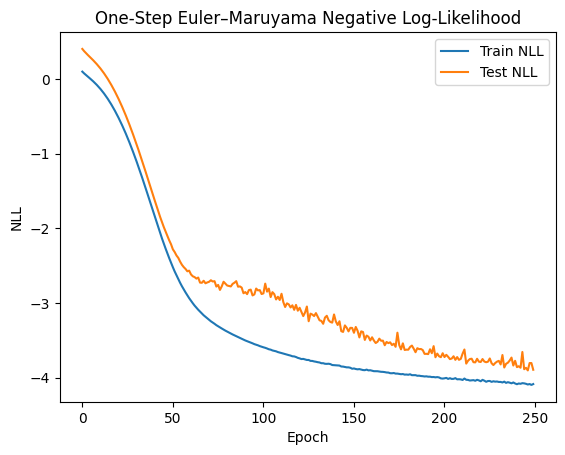

In [106]:


def _diag_sigma_grad(model, y):
    """
    Compute diagonal dσ_i/dy_i at y via autograd.
    y: (B, d) requires_grad=True
    returns: (B, d)
    """
    sigma = model.g(0.0, y)  # (B, d)
    grads = []
    for i in range(y.shape[1]):
        gi = sigma[:, i].sum()
        (grad_y,) = torch.autograd.grad(gi, y, retain_graph=True, create_graph=True)
        grads.append(grad_y[:, i:i+1])
    return torch.cat(grads, dim=1)

def ait_sahalia_quasi_nll(model, y0, y1, dt, eps_dt=1e-10, eps_sig=1e-10):
    """
    First-order Lamperti quasi-likelihood (Aït-Sahalia style) with diagonal diffusion:
      - z = ∫ dy/σ(y)  (approximated by dz ≈ (y1 - y0)/σ(y0))
      - μ_L = f/σ - 0.5 σ'
      - log p(y1|y0) ≈ N(z1; z0 + μ_L Δ, Δ) + log |∂z/∂y1| = N(...) + log σ(y1)
    Shapes:
      y0,y1: (B,d); dt: (B,1)
    """
    # Ensure autograd is enabled (needed for sigma' wrt inputs)
    with torch.enable_grad():
        # evaluate at y0
        y0_req = y0.detach().clone().requires_grad_(True)
        sigma0 = model.g(0.0, y0_req).clamp_min(eps_sig)     # (B,d)
        drift0 = model.f(0.0, y0_req)                         # (B,d)
        sigp0  = _diag_sigma_grad(model, y0_req)              # (B,d)
        mu_L   = drift0 / sigma0 - 0.5 * sigp0                # (B,d)

        # transformed increment and Jacobian at y1
        dz = (y1 - y0) / sigma0                               # (B,d)
        sigma1 = model.g(0.0, y1).clamp_min(eps_sig)          # (B,d)
        logJ = torch.log(sigma1)                              # (B,d)

        dtc = dt.clamp_min(eps_dt)                            # (B,1)
        w = (dz - mu_L * dtc) / torch.sqrt(dtc)               # (B,d)

        nll = 0.5 * (w**2 + torch.log(2 * math.pi * dtc)) + logJ
        return nll  # (B,d)

def ait_sahalia_quasi_nll_with_w(model, y0, y1, dt, eps_dt=1e-10, eps_sig=1e-10):
    # Gaussian Lamperti (per-dim), returns (nll_mat, w)
    with torch.enable_grad():
        y0_req = y0.detach().clone().requires_grad_(True)
        sigma0 = model.g(0.0, y0_req).clamp_min(eps_sig)
        drift0 = model.f(0.0, y0_req)
        sigp0  = _diag_sigma_grad(model, y0_req)
        mu_L   = drift0 / sigma0 - 0.5 * sigp0

        dz     = (y1 - y0) / sigma0
        sigma1 = model.g(0.0, y1).clamp_min(eps_sig)
        logJ   = torch.log(sigma1)

        dtc = dt.clamp_min(eps_dt)
        w   = (dz - mu_L * dtc) / torch.sqrt(dtc)

        nll = 0.5 * (w**2 + torch.log(2 * math.pi * dtc)) + logJ  # (B,d)
        return nll, w

import torch.nn as nn
import torchsde
import torch
import torch.optim as optim
import math
# Test and train tensors
# train_tensor_af = torch.load("train_tensor_af.pt")
# test_tensor_af = torch.load("test_tensor_af.pt")

# Load dt tensor
# dt_test = torch.load("dt_test.pt")
# dt_train = torch.load("dt_train.pt")


surf_train = train_tensor_af
surf_test = test_tensor_af

# # Standardise per node (use train stats)
# mu = surf_train.mean(0, keepdim=True)
# sd = surf_train.std(0, keepdim=True) + 1e-6
# surf_train = (surf_train - mu) / sd
# surf_test  = (surf_test  - mu) / sd

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)
n_train = surf_train.size(0)
n_test  = surf_test.size(0)
n_train, dim = surf_train.shape
n_test, _ = surf_test.shape

# align dt
dt_train = dt_train.to(device)
dt_test = dt_test.to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)

# # Normalize Δt so median(train) == 1; clamp for stability
# dt_scale = torch.median(dt_train_pairs).clamp_min(1e-6)
# dt_train_pairs = (dt_train_pairs / dt_scale).clamp(1e-6, 100.0)
# dt_test_pairs  = (dt_test_pairs  / dt_scale).clamp(1e-6, 100.0)

# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="general")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(dim).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-5)
n_epochs = 250
batch_size = 128


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(n_train - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        # nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        nll = ait_sahalia_quasi_nll(model, y0, y1, dt)
        loss = nll.mean()
        if torch.isnan(loss):
            print("NaN in NLL: ",
                  "var min/max:", var.min().item(), var.max().item(),
                  "drift min/max:", drift.min().item(), drift.max().item(),
                  "diff min/max:", diff.min().item(), diff.max().item(),
                  "dy min/max:", dy.min().item(), dy.max().item(),
                  "dt min/max:", dt.min().item(), dt.max().item())
            raise RuntimeError("NaN in loss")

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (n_train - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        print(y0_test.numel())
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        # nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        nll_t = ait_sahalia_quasi_nll(model, y0_test, y1_test, dt)
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")


# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()


In [107]:
# Standardised one-step residuals and PITs (train/test)
import torch
import numpy as np
from scipy import stats

with torch.no_grad():
    # Train
    y0_tr = surf_train[:-1]
    y1_tr = surf_train[1:]
    mu_tr = model.f(0, y0_tr)
    sg_tr = model.g(0, y0_tr).clamp_min(1e-9)
    dt_tr = dt_train_pairs.clamp_min(1e-12)
    w_tr = ((y1_tr - y0_tr) - mu_tr*dt_tr) / (sg_tr*torch.sqrt(dt_tr))
    w_tr_np = w_tr.detach().cpu().numpy()

    # Test
    y0_te = surf_test[:-1]
    y1_te = surf_test[1:]
    mu_te = model.f(0, y0_te)
    sg_te = model.g(0, y0_te).clamp_min(1e-9)
    dt_te = dt_test_pairs.clamp_min(1e-12)
    w_te = ((y1_te - y0_te) - mu_te*dt_te) / (sg_te*torch.sqrt(dt_te))
    w_te_np = w_te.detach().cpu().numpy()

# Probability integral transform (under Gaussian EM kernel)
pit_tr = stats.norm.cdf(w_tr_np)
pit_te = stats.norm.cdf(w_te_np)

print("Residual shapes: train", w_tr_np.shape, " test", w_te_np.shape)

Residual shapes: train (8817, 24)  test (1544, 24)


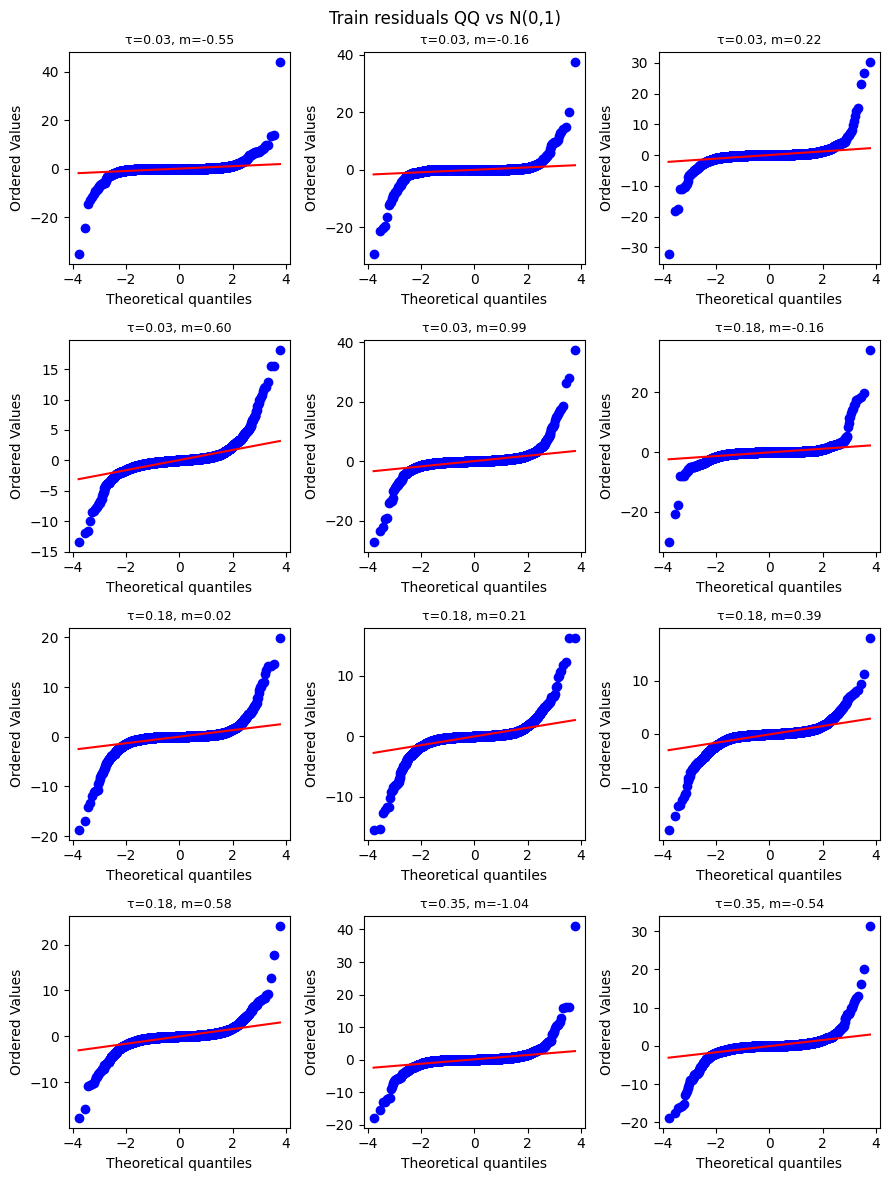

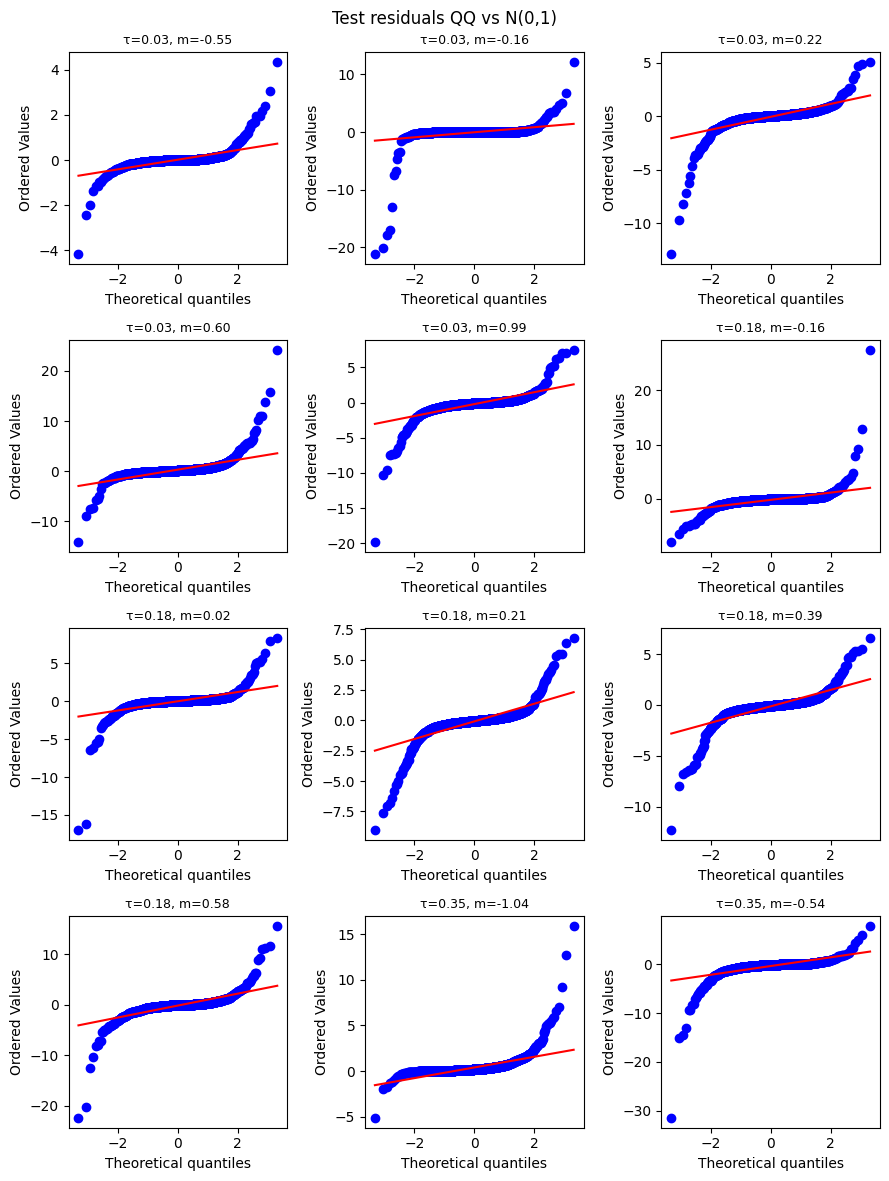

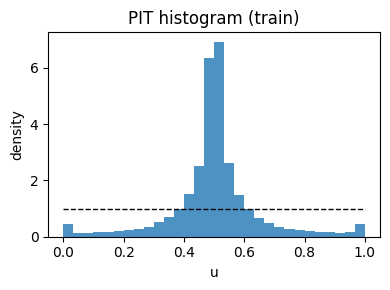

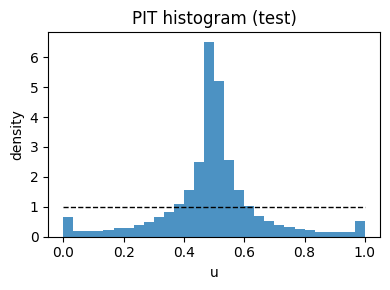

In [108]:
# ...existing code...
# QQ panels and PIT histograms
import matplotlib.pyplot as plt
from math import ceil

# Build per-dimension labels from lattice nodes (aligns with train_proj/test_proj columns)
try:
    node_labels = [f"τ={float(t):.2f}, m={float(m):.2f}" for (t, m) in common_nodes]
except Exception:
    # Fallback (e.g., when using Xi factors)
    node_labels = [f"dim {j}" for j in range(w_tr_np.shape[1])]

def qq_grid(w, title, labels=None, max_cols=3, max_dims=12):
    d = w.shape[1]
    keep = min(d, max_dims)
    cols = min(max_cols, keep)
    rows = ceil(keep/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.0, rows*3.0))
    axes = np.atleast_1d(axes).ravel()
    for j in range(keep):
        stats.probplot(w[:, j], dist="norm", plot=axes[j])
        lbl = (labels[j] if (labels is not None and j < len(labels)) else f"dim {j}")
        axes[j].set_title(lbl, fontsize=9)
    for k in range(keep, len(axes)): axes[k].axis("off")
    fig.suptitle(title, y=0.98); plt.tight_layout(); plt.show()

def pit_hist(u, title):
    plt.figure(figsize=(4,3))
    plt.hist(u.reshape(-1), bins=30, range=(0,1), density=True, alpha=0.8)
    plt.plot([0,1],[1,1], 'k--', lw=1)
    plt.title(title); plt.xlabel("u"); plt.ylabel("density"); plt.tight_layout(); plt.show()

qq_grid(w_tr_np, "Train residuals QQ vs N(0,1)", labels=node_labels)
qq_grid(w_te_np, "Test residuals QQ vs N(0,1)",  labels=node_labels)
pit_hist(pit_tr, "PIT histogram (train)")
pit_hist(pit_te, "PIT histogram (test)")
# ...existing code...

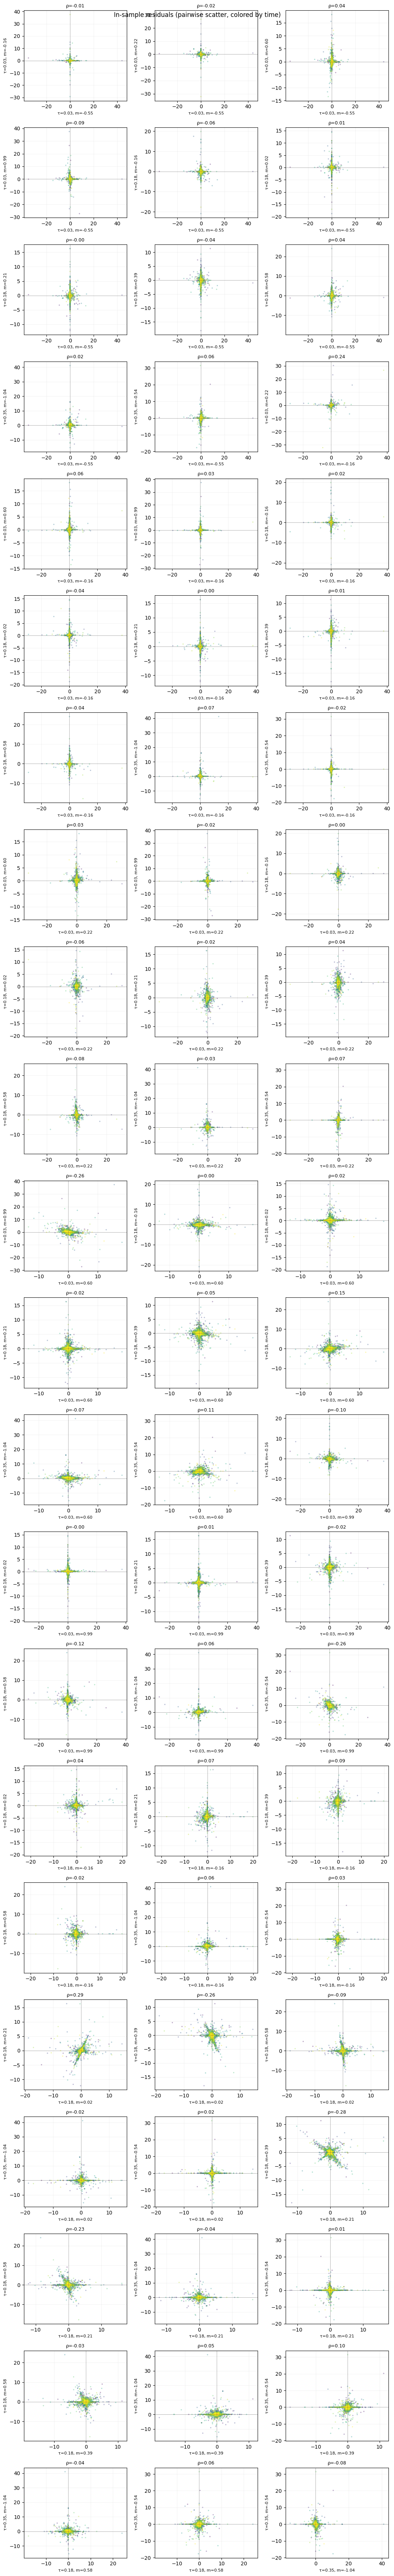

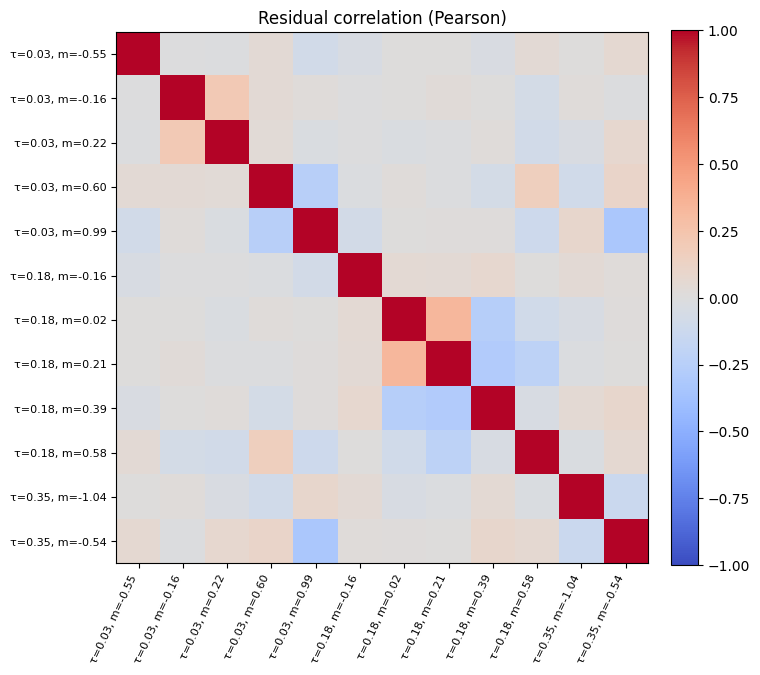

Top correlated residual pairs:
  (τ=0.18, m=0.02, τ=0.18, m=0.21): rho=+0.330
  (τ=0.03, m=0.99, τ=0.35, m=-0.54): rho=-0.326
  (τ=0.18, m=0.21, τ=0.18, m=0.39): rho=-0.288
  (τ=0.18, m=0.02, τ=0.18, m=0.39): rho=-0.259
  (τ=0.03, m=0.60, τ=0.03, m=0.99): rho=-0.248
  (τ=0.18, m=0.21, τ=0.18, m=0.58): rho=-0.218
  (τ=0.03, m=-0.16, τ=0.03, m=0.22): rho=+0.211
  (τ=0.03, m=0.60, τ=0.18, m=0.58): rho=+0.164
  (τ=0.35, m=-1.04, τ=0.35, m=-0.54): rho=-0.126
  (τ=0.03, m=0.99, τ=0.18, m=0.58): rho=-0.110


In [109]:
# ...existing code...
# In-sample residual scatter analysis (pairwise) on train w
import numpy as np, matplotlib.pyplot as plt
from itertools import combinations

def scatter_grid_residuals(W, labels=None, max_dims=12, max_cols=3, sample=8000, point_size=6):
    """
    W: numpy array of residuals, shape (T-1, d); e.g., w_tr_np
    labels: list[str] for axes titles (e.g., node_labels)
    """
    Tm1, d = W.shape
    keep = min(d, max_dims)
    rng = np.random.RandomState(0)
    idx = rng.choice(Tm1, size=min(sample, Tm1), replace=False)
    X = W[idx, :keep]
    # color by (relative) time to reveal non-stationarity
    c = np.linspace(0, 1, len(idx))

    pairs = list(combinations(range(keep), 2))
    cols = min(max_cols, max(1, len(pairs)))
    rows = int(np.ceil(len(pairs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.6, rows*3.2), squeeze=False)
    axes = axes.ravel()

    for ax, (i, j) in zip(axes, pairs):
        xi, yi = X[:, i], X[:, j]
        rho = float(np.corrcoef(xi, yi)[0, 1])
        xl = labels[i] if labels and i < len(labels) else f"dim {i}"
        yl = labels[j] if labels and j < len(labels) else f"dim {j}"
        ax.scatter(xi, yi, c=c, s=point_size, cmap="viridis", alpha=0.35, edgecolors="none")
        ax.axhline(0, color="k", lw=0.5, alpha=0.4); ax.axvline(0, color="k", lw=0.5, alpha=0.4)
        ax.set_xlabel(xl, fontsize=8); ax.set_ylabel(yl, fontsize=8)
        ax.set_title(f"ρ={rho:.2f}", fontsize=9)
        ax.grid(alpha=0.15)
    for k in range(len(pairs), len(axes)):
        fig.delaxes(axes[k])
    fig.suptitle("In-sample residuals (pairwise scatter, colored by time)", y=0.99)
    plt.tight_layout(); plt.show()

    # Correlation heatmap for the same kept dimensions
    C = np.corrcoef(W[:, :keep].T)
    plt.figure(figsize=(0.5+keep*0.6, 0.5+keep*0.6))
    im = plt.imshow(C, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    xt = [labels[i] if labels and i < len(labels) else f"{i}" for i in range(keep)]
    plt.xticks(range(keep), xt, rotation=65, ha="right", fontsize=8)
    plt.yticks(range(keep), xt, fontsize=8)
    plt.title("Residual correlation (Pearson)")
    plt.tight_layout(); plt.show()

    # Print top correlated pairs
    tri = np.triu_indices(keep, k=1)
    vals = C[tri]
    order = np.argsort(-np.abs(vals))
    print("Top correlated residual pairs:")
    for r in order[:min(10, len(order))]:
        i, j = tri[0][r], tri[1][r]
        print(f"  ({xt[i]}, {xt[j]}): rho={C[i,j]:+.3f}")

# Run on train residuals computed earlier (w_tr_np)
scatter_grid_residuals(w_tr_np, labels=node_labels, max_dims=12, max_cols=3, sample=6000, point_size=6)
# ...existing code...

In [103]:
# ...existing code...
import numpy as np
import pandas as pd

def shepard_weights(tau_star: float, m_star: float, nodes: np.ndarray, K: int = 4, p: float = 2.0):
    """
    Inverse-distance weights over K nearest lattice nodes.
    nodes: array [[tau_i, m_i]] in the same order as columns of train_proj/test_proj.
    Returns (idx: np.ndarray[K], w: np.ndarray[K], coords: np.ndarray[K,2])
    """
    dx = nodes - np.array([tau_star, m_star])[None, :]
    dist = np.sqrt((dx**2).sum(axis=1)) + 1e-12
    idx = np.argpartition(dist, K)[:K]
    dK = dist[idx]
    w = (1.0 / (dK**p))
    w = w / w.sum()
    return idx.astype(int), w.astype(float), nodes[idx]

def instrument_grad_wrt_surface(F_star: float, tau_star: float, m_star: float,
                                nodes: np.ndarray, N: int, K: int = 4):
    """
    ∂Price/∂y ≈ F_star * w over K nearest nodes to (tau_star, m_star), 0 elsewhere.
    y are normalized call prices c = C/F.
    """
    idx, w, _ = shepard_weights(tau_star, m_star, nodes, K=K)
    grad = np.zeros(N, dtype=float)
    grad[idx] = F_star * w
    return grad, idx, w

def min_var_hedge_weights(y_vec: np.ndarray, g_vec: np.ndarray,
                          v_target: np.ndarray, A_hedge: np.ndarray, lam_ridge: float = 1e-8):
    """
    Solve w* = argmin_w || D^(1/2)(v_target - A_hedge w) ||^2 with D = diag(g^2).
    y_vec: current state [N], g_vec: diffusion diag [N], v_target: [N], A_hedge: [N, H]
    Returns w (H,), residual_var.
    """
    Dg = (g_vec**2).reshape(-1, 1)                   # [N,1]
    Aw = A_hedge * np.sqrt(Dg)                       # [N,H]
    vw = v_target * np.sqrt(Dg.ravel())              # [N]
    G = Aw.T @ Aw + lam_ridge * np.eye(Aw.shape[1])  # [H,H]
    b = Aw.T @ vw                                    # [H]
    w = np.linalg.solve(G, b)
    resid = vw - Aw @ w
    resid_var = float(np.dot(resid, resid) / max(1, len(resid)))
    return w, resid_var

# ---- Example: hedge one option with nearby lattice options (+ optional spot) ----
# Inputs assumed available from earlier cells:
# - model: trained SurfaceSDE  -> [`qa_testing.SurfaceSDE`](qa_testing.ipynb)
# - common_nodes: lattice coordinates used for train_proj/test_proj columns
# - train_proj/test_proj: projected (no-arb) normalized call surfaces C/F
# - df: raw Deribit snapshot with tau, m, F computed by clean_deribit()

def build_option_hedge(model, current_surface: pd.Series, nodes: np.ndarray,
                       target_tau: float, target_m: float, F_star: float,
                       hedge_K: int = 6, include_spot: bool = False, r: float = 0.0, q: float = 0.0,
                       include_target_nodes: bool = True):
    """
    Returns:
      weights: dict { 'node:<idx>': w_i, 'spot': w_S (optional) }
      resid_var: instantaneous residual variance proxy
    """
    device = next(model.parameters()).device
    y = torch.from_numpy(current_surface.values.astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        g = model.g(0.0, y).squeeze(0).clamp_min(1e-9).cpu().numpy()  # [N]
    N = len(current_surface)

    # Target gradient wrt surface state
    v_tar, tgt_idx, tgt_w = instrument_grad_wrt_surface(F_star, target_tau, target_m, nodes, N, K=4)

    # Choose hedge nodes
    idx_all, _, _ = shepard_weights(target_tau, target_m, nodes, K=max(hedge_K+4, 8))
    if include_target_nodes:
        # Put target-support nodes first so we can match v_tar where it is nonzero
        order = list(dict.fromkeys([*tgt_idx, *idx_all]))
        hedge_idx = order[:hedge_K]
    else:
        hedge_idx = [i for i in idx_all if i not in set(tgt_idx)][:hedge_K] or list(idx_all[:hedge_K])

    # Build hedge gradient columns (each hedger is a lattice option at node h)
    A_cols, labels = [], []
    for h in hedge_idx:
        col = np.zeros(N, dtype=float); col[h] = F_star
        A_cols.append(col); labels.append(f"node:{h}")
    A = np.column_stack(A_cols) if A_cols else np.zeros((N, 0), float)

    # Optional spot column (kept as zero exposure in this state basis)
    if include_spot:
        colS = np.zeros(N, dtype=float)
        A = np.column_stack([A, colS]) if A_cols else colS.reshape(-1, 1)
        labels.append("spot")

    w, resid_var = min_var_hedge_weights(current_surface.values, g, v_tar, A, lam_ridge=1e-6)
    weights = {lab: float(wi) for lab, wi in zip(labels, w)}
    return weights, resid_var

# Example usage (last train snapshot, hedge a near-ATM 30d call using 6 nearby lattice options)
last_row = train_proj.iloc[-1]  # [`qa_testing.train_proj`](qa_testing.ipynb)
# pick a target from df at the last timestamp
ts_last = last_row.name
snap = df[df['timestamp'] == ts_last]
# near-ATM, ~30d
cand = (snap.assign(abs_m=lambda x: np.abs(x['m']))
             .sort_values(['abs_m', 'tau']).iloc[0])
target_tau = float(cand['tau']); target_m = float(cand['m']); F_star = float(cand['F'])

weights, resid_var = build_option_hedge(
    model, last_row, common_nodes, target_tau, target_m, F_star,
    hedge_K=6, include_spot=False, r=0.0, q=0.0
)
print("Hedge weights:", weights, " residual variance proxy:", resid_var)
# ...existing code...

Hedge weights: {'node:1': 0.5039609521804885, 'node:6': 0.05699368599632063, 'node:5': 0.40891116056417137, 'node:12': 0.030134201258813945, 'node:7': 0.0, 'node:0': 0.0}  residual variance proxy: 3.465544262124801e-21


In [104]:
# ...existing code...
from utils.black_scholes import implied_vol_from_c_norm  # [`utils.black_scholes.implied_vol_from_c_norm`](utils/black_scholes.py)

def forecast_next_iv_surface_em(model,                  # trained qa_testing.SurfaceSDE
                                last_surface: pd.Series, # last row of train_proj/test_proj (indexed by node_idx)
                                nodes: np.ndarray,       # common_nodes [N,2] with columns (tau, m)
                                S_last: float,           # median underlying at last timestamp
                                horizon_s: float = 60.0, # Δt in SECONDS (matches your training dt units)
                                r: float = 0.0, q: float = 0.0,
                                assume_normalized: bool = True
                                ) -> pd.Series:
    """
    One-step IV projection:
      - EM mean step on surface state: ȳ = y + f(y) Δt
      - Convert projected call price to implied vol via Black–Scholes inversion per node.
    """
    y = torch.from_numpy(last_surface.values.astype(np.float32)).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        f = model.f(0.0, y)
        y_mean = (y + f * horizon_s).squeeze(0).cpu().numpy()  # EM mean; ignore diffusion for IV point-forecast

    taus = nodes[:, 0].astype(float)
    ms   = nodes[:, 1].astype(float)

    # normalized call prices c = C/F; if last_surface is not normalized, divide by F_t per node
    if assume_normalized:
        c_norm = np.clip(y_mean, 1e-10, 1.0)
    else:
        F_vec = S_last * np.exp((r - q) * taus)       # per-node forward at last time
        c_norm = np.clip(y_mean / F_vec, 1e-10, 1.0)

    # time to expiry decreases by Δt
    tau_next = np.maximum(taus - horizon_s / (365.0*24*3600), 1e-8)

    iv = implied_vol_from_c_norm(c_norm, ms, tau_next)  # vectorized per-node IV
    return pd.Series(iv, index=last_surface.index, name="iv_next")

# Example usage on the last train surface:
last_ts = train_proj.index[-1]
S_last  = float(train_df[train_df['timestamp'] == last_ts]['underlying_price'].median())
iv_next = forecast_next_iv_surface_em(
    model,                             # qa_testing.SurfaceSDE instance
    train_proj.iloc[-1],               # last observed projected surface
    common_nodes,                      # [N,2] (tau, m)
    S_last,
    horizon_s=60.0,                    # 1-minute ahead IV
    r=0.0, q=0.0,
    assume_normalized=True             # set False if your train_proj stores raw prices
)
print(iv_next.head())
# ...existing code...

node_idx
0    3.453524
1    0.151308
2    1.168509
3    1.944061
4    2.320482
Name: iv_next, dtype: float64


                 mean     std  sharpe     q05     q95
unhedged       0.0017  0.0057  0.3056 -0.0053  0.0146
bs_delta_only  0.2822  0.1806  1.5627 -0.0039  0.5443
bs_delta_vega  0.1418  0.1064  1.3327 -0.0228  0.3157


<Axes: title={'center': 'P&L comparison (BS hedges)'}, xlabel='timestamp'>

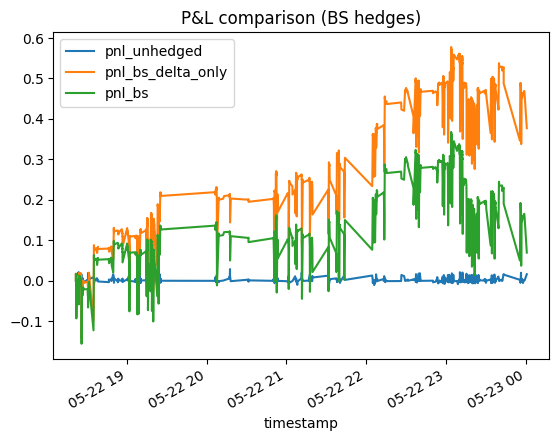

In [110]:
import numpy as np
import pandas as pd

# -----------------------------
# Black–Scholes utilities
# -----------------------------
from math import log, sqrt, exp
from scipy.stats import norm

def _bs_call_price(S, K, tau, r=0.0, q=0.0, sigma=0.2):
    if tau <= 0 or sigma <= 1e-12:
        return max(S*np.exp(-q*tau) - K*np.exp(-r*tau), 0.0)
    F = S*np.exp((r-q)*tau)
    vol = sigma*sqrt(tau)
    d1 = (np.log(F/K) + 0.5*vol*vol) / vol
    d2 = d1 - vol
    return np.exp(-r*tau)*(F*norm.cdf(d1) - K*norm.cdf(d2))

def _bs_greeks_call(S, K, tau, r=0.0, q=0.0, sigma=0.2):
    """Returns (delta, vega) for a **call**. vega per 1.00 vol (not %)"""
    if tau <= 0 or sigma <= 1e-12:
        # At expiry, delta ≈ 1{S>Ke^{-rτ}}*e^{-qτ}
        delta = float(S*np.exp(-q*tau) > K*np.exp(-r*tau)) * np.exp(-q*tau)
        return delta, 0.0
    F = S*np.exp((r-q)*tau)
    vol = sigma*sqrt(tau)
    d1 = (np.log(F/K) + 0.5*vol*vol) / vol
    delta = np.exp(-q*tau)*norm.cdf(d1)
    vega  = np.exp(-r*tau)*F*norm.pdf(d1)*sqrt(tau)  # ∂Price/∂sigma
    return float(delta), float(vega)

def _implied_vol_call(price, S, K, tau, r=0.0, q=0.0, 
                      lo=1e-6, hi=5.0, tol=1e-7, maxit=100):
    """Robust bisection (works well on HF noisy panels)."""
    # intrinsic / upper bounds sanity
    disc = np.exp(-r*tau); dq = np.exp(-q*tau)
    intrinsic = max(S*dq - K*disc, 0.0)
    if price <= intrinsic + 1e-12: 
        return lo
    # widen hi if needed
    f_lo = _bs_call_price(S,K,tau,r,q,lo) - price
    f_hi = _bs_call_price(S,K,tau,r,q,hi) - price
    iters = 0
    while f_hi < 0 and hi < 50.0:
        hi *= 2.0
        f_hi = _bs_call_price(S,K,tau,r,q,hi) - price
        iters += 1
        if iters > 10: break
    # bisection
    for _ in range(maxit):
        mid = 0.5*(lo+hi)
        f_mid = _bs_call_price(S,K,tau,r,q,mid) - price
        if abs(f_mid) < tol or (hi-lo) < 1e-7:
            return float(max(mid, 1e-8))
        if np.sign(f_mid) == np.sign(f_lo):
            lo, f_lo = mid, f_mid
        else:
            hi = mid
    return float(max(0.5*(lo+hi), 1e-8))

# -----------------------------
# Hedging backtest
# -----------------------------
SEC_PER_YEAR = 365.25*24*3600.0

def _decaying_tau(index, tau0_years, t0=None):
    """Compute τ_t = max(τ0 - (t - t0)/year, 1e-8) along the index."""
    ts = pd.to_datetime(index)
    if t0 is None: 
        t0 = ts[0]
    elap_s = (ts - t0).astype('timedelta64[ns]').astype(np.int64)/1e9
    tau_t = np.maximum(tau0_years - elap_s/SEC_PER_YEAR, 1e-8)
    return pd.Series(tau_t, index=index)

def _one_step_hedge_positions_BS(S, C_tgt, C_hdg, K_tgt, K_hdg, tau_tgt, tau_hdg, 
                                 r=0.0, q=0.0):
    """
    For each time t, compute BS Δ, V for target and hedge option (calls).
    Hedge is: long 1 target; hold -Δ_target in spot; and -h in hedge option,
    where h = Vega_target / Vega_hedge (vega-neutral).
    Returns DataFrame with columns: delta_tgt, vega_tgt, delta_hdg, vega_hdg, h (hedge units).
    """
    out = []
    for t in C_tgt.index:
        S_t = float(S.loc[t])
        Ct  = float(C_tgt.loc[t])
        Ch  = float(C_hdg.loc[t])
        tauT= float(tau_tgt.loc[t])
        tauH= float(tau_hdg.loc[t])
        # implied vols
        sigT = _implied_vol_call(Ct, S_t, K_tgt, tauT, r=r, q=q)
        sigH = _implied_vol_call(Ch, S_t, K_hdg, tauH, r=r, q=q)
        dT, vT = _bs_greeks_call(S_t, K_tgt, tauT, r=r, q=q, sigma=sigT)
        dH, vH = _bs_greeks_call(S_t, K_hdg, tauH, r=r, q=q, sigma=sigH)
        h = 0.0 if abs(vH) < 1e-12 else (vT / vH)
        out.append((dT, vT, dH, vH, h))
    cols = ['delta_tgt','vega_tgt','delta_hdg','vega_hdg','h_units']
    return pd.DataFrame(out, index=C_tgt.index, columns=cols)

def _self_financing_pnl(S, C_tgt, C_hdg, pos_df, r=0.0, q=0.0, fee_bps=0.0, rehedge_every=1):
    """
    Discrete self-financing P&L for the portfolio:
      Π_t = +1*Target  -Δ_t*Spot  -h_t*Hedge  + cash
    Re-hedge every 'rehedge_every' steps. fee_bps is proportional to traded notional.
    """
    idx = C_tgt.index
    # initialize positions
    unit_tgt = 1.0
    delta    = np.zeros(len(idx))
    hedge_u  = np.zeros(len(idx))
    cash     = np.zeros(len(idx))
    # initial positions
    delta[0]   = -pos_df['delta_tgt'].iloc[0]
    hedge_u[0] = -pos_df['h_units'].iloc[0]
    cash[0]    = - (delta[0]*S.iloc[0] + hedge_u[0]*C_hdg.iloc[0])  # financing
    # costs on initial trade
    if fee_bps > 0:
        cash[0] -= abs(delta[0])*S.iloc[0]*(fee_bps*1e-4)
        cash[0] -= abs(hedge_u[0])*C_hdg.iloc[0]*(fee_bps*1e-4)
    # evolve
    pnl = np.zeros(len(idx))
    for t in range(1, len(idx)):
        dt_years = (idx[t]-idx[t-1]).total_seconds()/SEC_PER_YEAR
        # cash accrues at r
        cash[t] = cash[t-1]*np.exp(r*dt_years)
        # portfolio value before re-hedge
        val_before = (unit_tgt*C_tgt.iloc[t] + delta[t-1]*S.iloc[t] + hedge_u[t-1]*C_hdg.iloc[t] + cash[t])
        pnl[t] = val_before
        # decide to re-hedge
        if (t % rehedge_every) != 0:
            delta[t]   = delta[t-1]
            hedge_u[t] = hedge_u[t-1]
            continue
        # new target positions
        new_delta = -pos_df['delta_tgt'].iloc[t]
        new_hedge = -pos_df['h_units'].iloc[t]
        # trades
        d_delta = new_delta - delta[t-1]
        d_hedge = new_hedge - hedge_u[t-1]
        cash[t] -= (d_delta*S.iloc[t] + d_hedge*C_hdg.iloc[t])
        if fee_bps > 0:
            cash[t] -= (abs(d_delta)*S.iloc[t] + abs(d_hedge)*C_hdg.iloc[t])*(fee_bps*1e-4)
        delta[t], hedge_u[t] = new_delta, new_hedge
        # portfolio value after re-hedge (mark)
        pnl[t] = unit_tgt*C_tgt.iloc[t] + delta[t]*S.iloc[t] + hedge_u[t]*C_hdg.iloc[t] + cash[t]
    # convert to P&L (vs initial mark)
    pnl -= pnl[0]
    res = pd.DataFrame({
        'pnl': pnl,
        'cash': cash,
        'delta_pos': delta,
        'hedge_units': hedge_u
    }, index=idx)
    return res

def backtest_compare(C_target: pd.Series,
                     C_hedge: pd.Series,
                     S: pd.Series,
                     m_target: float,
                     tau0_target: float,
                     m_hedge: float,
                     tau0_hedge: float,
                     r: float = 0.0,
                     q: float = 0.0,
                     fee_bps: float = 0.0,
                     rehedge_every: int = 1,
                     t0=None,
                     model_delta: pd.Series = None,
                     model_vega:  pd.Series = None):
    """
    Compare **BS delta-vega hedge** to your **model hedge** (if model greeks are supplied).
    m_* are log-moneyness on your lattice (so K_t = F_t * exp(m)).
    tau0_* are the lattice taus (years) at t0; they decay over time automatically.
    """
    # sync & sort
    df = pd.concat([C_target, C_hedge, S], axis=1).dropna().sort_index()
    C_target, C_hedge, S = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2]

    # τ decay and strikes from lattice (using *current* S for F each time step)
    tau_tgt = _decaying_tau(df.index, tau0_target, t0=t0)
    tau_hdg = _decaying_tau(df.index, tau0_hedge,  t0=t0)

    # strikes use forward at t0; for intraday, using F(t) is also fine.
    # Here we lock K to t0 forward to avoid path-dependence in K.
    S0  = float(S.iloc[0])
    F0  = S0*np.exp((r-q)*tau0_target)
    K_tgt = float(F0*np.exp(m_target))
    F0h = S0*np.exp((r-q)*tau0_hedge)
    K_hdg = float(F0h*np.exp(m_hedge))

    # 1) BS hedge ratios through time
    pos_df = _one_step_hedge_positions_BS(S, C_target, C_hedge, K_tgt, K_hdg, tau_tgt, tau_hdg, r=r, q=q)

    # 2) P&L with BS delta-vega hedge
    pnl_bs = _self_financing_pnl(S, C_target, C_hedge, pos_df, r=r, q=q, fee_bps=fee_bps, rehedge_every=rehedge_every)
    pnl_bs.rename(columns={'pnl':'pnl_bs'}, inplace=True)

    # 3) Optional: your model hedge (pass model_delta & model_vega for target only)
    out = pnl_bs.copy()
    if (model_delta is not None) and (model_vega is not None):
        # replicate the same structure: vega-neutral with the **same hedge option**
        md = pd.concat([model_delta, model_vega], axis=1).reindex(df.index).ffill().bfill()
        md.columns = ['delta_tgt','vega_tgt']
        # need hedge vega (BS, from step 1)
        h_units = md['vega_tgt'] / (pos_df['vega_hdg'].replace(0.0, np.nan))
        h_units = h_units.replace([np.inf, -np.inf], 0.0).fillna(0.0)
        model_pos = pd.DataFrame({
            'delta_tgt': md['delta_tgt'],
            'h_units': h_units
        }, index=df.index)
        # wrap into the same runner by faking 'pos_df' columns
        pos_df_model = pd.DataFrame({
            'delta_tgt': model_pos['delta_tgt'],
            'h_units': model_pos['h_units'],
            'delta_hdg': pos_df['delta_hdg'],  # unused by pnl function
            'vega_tgt':  md['vega_tgt'],
            'vega_hdg':  pos_df['vega_hdg'],
        }, index=df.index)
        pnl_model = _self_financing_pnl(S, C_target, C_hedge, pos_df_model, r=r, q=q, fee_bps=fee_bps, rehedge_every=rehedge_every)
        out['pnl_model'] = pnl_model['pnl']

    # 4) Baselines: unhedged and delta-only (BS)
    unhedged = (C_target - C_target.iloc[0]).rename('pnl_unhedged')
    out = out.join(unhedged)
    # delta-only (no vega hedge; reuse pos_df with h=0)
    pos_delta_only = pos_df.copy()
    pos_delta_only['h_units'] = 0.0
    pnl_delta_only = _self_financing_pnl(S, C_target, C_hedge, pos_delta_only, r=r, q=q, fee_bps=fee_bps, rehedge_every=rehedge_every)
    out['pnl_bs_delta_only'] = pnl_delta_only['pnl']

    # 5) Small summary
    def _stats(x):
        x = x.values
        return dict(
            mean=x.mean(),
            std=x.std(ddof=1),
            sharpe=(x.mean()/x.std(ddof=1) if x.std(ddof=1)>0 else np.nan),
            q05=np.quantile(x, 0.05),
            q95=np.quantile(x, 0.95)
        )
    report = {
        'unhedged': _stats(out['pnl_unhedged']),
        'bs_delta_only': _stats(out['pnl_bs_delta_only']),
        'bs_delta_vega': _stats(out['pnl_bs']),
    }
    if 'pnl_model' in out.columns:
        report['model_delta_vega'] = _stats(out['pnl_model'])

    return out, report

# Suppose you already have:
#   train_proj/test_proj  -> DataFrame [time × node_idx] of normalized call prices c \in [0,1]
#   full_nodes            -> array [N,2] with (τ, m) for each node_idx
#   Underlying mid series S (aligned with the DataFrame index)
#   And you want, say, τ*=0.18, m*≈0.21 as your target,
#   and the hedge is the nearest (same τ*, m≈0).

panel = test_proj  # or train_proj
S = df.groupby('timestamp')['underlying_price'].median()  # or your cleaned series
S = S.reindex(panel.index).ffill().bfill()

# pick target and hedge node indices
nodes = full_nodes[panel.columns.astype(int)]
tau_vals = np.unique(nodes[:,0])
tau_star = sorted(tau_vals)[1]           # example: choose the middle τ
m_star   = 0.21                          # your chosen target m
# find nearest nodes
i_target = np.argmin(np.abs(nodes[:,0]-tau_star) + np.abs(nodes[:,1]-m_star))
i_hedge  = np.argmin(np.abs(nodes[:,0]-tau_star) + np.abs(nodes[:,1]-0.00))

C_target = panel.iloc[:, i_target]
C_hedge  = panel.iloc[:, i_hedge]
tau0_target = float(nodes[i_target,0])
tau0_hedge  = float(nodes[i_hedge,0])
m_target    = float(nodes[i_target,1])
m_hedge     = float(nodes[i_hedge,1])

# (Optional) your model greeks as Series aligned to panel.index
model_delta = None   # pd.Series(...)
model_vega  = None   # pd.Series(...)

pnl_df, rpt = backtest_compare(
    C_target=C_target, C_hedge=C_hedge, S=S,
    m_target=m_target, tau0_target=tau0_target,
    m_hedge=m_hedge,   tau0_hedge=tau0_hedge,
    r=0.0, q=0.0, fee_bps=0.0,
    rehedge_every=1,
    model_delta=model_delta, model_vega=model_vega
)

print(pd.DataFrame(rpt).T.round(4))
pnl_df[['pnl_unhedged','pnl_bs_delta_only','pnl_bs']].plot(title='P&L comparison (BS hedges)')


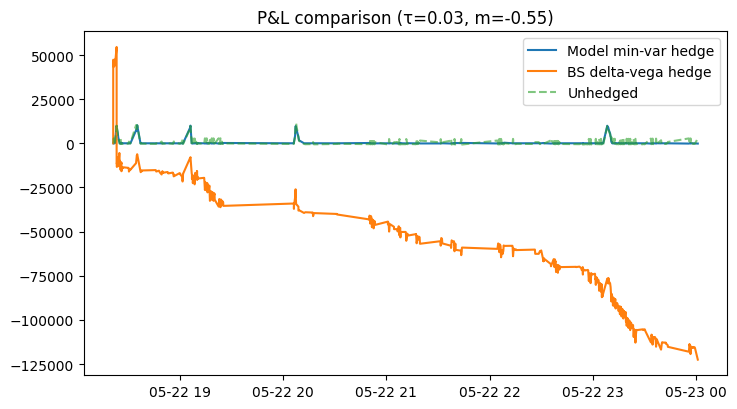

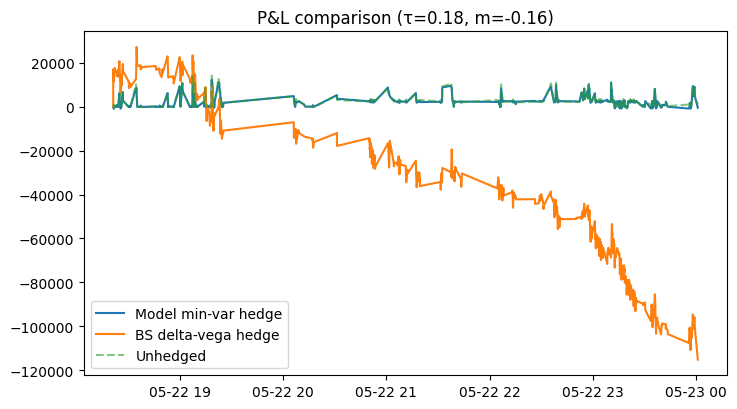

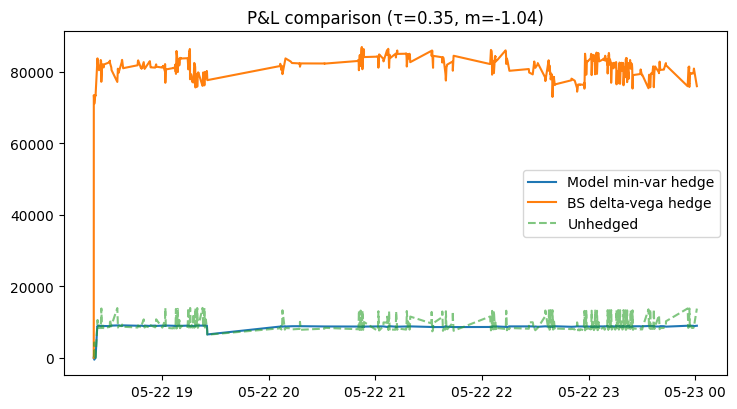

Summary (per-target Sharpe of incremental P&L):


,hedge_idx,mv_sharpe,bs_sharpe,unhedged_sharpe
target_idx,,,,
0,1,-0.000150,-0.031949,0.001808
5,6,-0.000272,-0.035569,0.000542
10,12,0.024487,0.022498,0.006986


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

def min_var_hedge(dC_target, dC_hedges):
    """
    One-step minimum variance hedge ratio via regression.
    dC_target: (T-1,)
    dC_hedges: (T-1, k)
    Returns hedge ratios (k,)
    """
    reg = LinearRegression(fit_intercept=False).fit(dC_hedges, dC_target)
    return reg.coef_

def run_backtest(position_idx, hedge_idx, S_series, panel_df, tau0, m0, r=0.0, q=0.0):
    """
    Compare P&L of model's min-var hedge vs BS delta-vega hedge for one option.
    position_idx: column idx of target option in panel_df
    hedge_idx: column idx of hedge option (for vega hedge)
    """
    C_tgt = panel_df.iloc[:, position_idx]
    C_hed = panel_df.iloc[:, hedge_idx]
    S = S_series.reindex(panel_df.index).ffill().bfill()

    # 1) Target log-returns
    dC_tgt = C_tgt.diff().dropna().values.reshape(-1,1)
    dS = S.diff().dropna().values.reshape(-1,1)
    dC_hed = C_hed.diff().dropna().values.reshape(-1,1)

    # 2) --- Model hedge (min variance wrt spot + hedge option) ---
    X = np.hstack([dS, dC_hed])
    h_model = min_var_hedge(dC_tgt[1:], X[1:])   # use regression on differences
    pnl_model = dC_tgt.flatten() - X @ h_model
    pnl_model = np.cumsum(pnl_model)

    # 3) --- BS delta-vega hedge (your helper from before) ---
    pnl_bs_df, rpt = backtest_compare(
        C_target=C_tgt, C_hedge=C_hed, S=S,
        m_target=m0, tau0_target=tau0,
        m_hedge=float(common_nodes[hedge_idx,1]), tau0_hedge=float(common_nodes[hedge_idx,0]),
        r=r, q=q, fee_bps=0.0
    )

    # 4) Plot comparison
    plt.figure(figsize=(7,4))
    plt.plot(C_tgt.index[1:], pnl_model, label="Model min-var hedge")
    plt.plot(pnl_bs_df.index, pnl_bs_df['pnl_bs'], label="BS delta-vega hedge")
    plt.plot(pnl_bs_df.index, pnl_bs_df['pnl_unhedged'], label="Unhedged", ls="--", alpha=0.5)
    plt.title(f"P&L comparison (τ={tau0:.2f}, m={m0:.2f})")
    plt.legend(); plt.tight_layout(); plt.show()

    return pnl_model, pnl_bs_df

# ----------------------------
# ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def price_series_from_normalized(c_series: pd.Series,
                                 tau0: float,
                                 S_series: pd.Series,
                                 r: float = 0.0,
                                 q: float = 0.0) -> pd.Series:
    """
    Convert normalized call c=C/F in panel units to dollar prices C_t = c_t * F_t,
    where F_t = S_t * exp((r - q) * tau_t) and tau_t decays from tau0.
    """
    c = c_series.sort_index()
    S = S_series.reindex(c.index).ffill().bfill()
    tau_t = _decaying_tau(c.index, tau0)  # [`qa_testing._decaying_tau`](qa_testing.ipynb)
    F_t = S * np.exp((r - q) * tau_t)
    return pd.Series(c.values * F_t.values, index=c.index, name=c.name)

def min_var_hedge(dC_target, dC_hedges):
    """
    One-step minimum variance hedge ratio via regression.
    dC_target: (T-1,) or (T-1,1)
    dC_hedges: (T-1, k)
    Returns hedge ratios (k,)
    """
    y = np.asarray(dC_target).ravel()
    X = np.asarray(dC_hedges)
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    return reg.coef_.ravel()

def run_backtest_mv_vs_bs(position_idx: int,
                          hedge_idx: int,
                          S_series: pd.Series,
                          panel_df: pd.DataFrame,
                          nodes: np.ndarray,
                          r: float = 0.0,
                          q: float = 0.0):
    """
    Compare model min-var hedge to BS delta–vega hedge for a single target/hedge pair.
    panel_df is normalized prices (c=C/F); nodes aligned with panel_df columns.
    """
    # Target/hedge normalized series
    c_tgt = panel_df.iloc[:, position_idx]
    c_hed = panel_df.iloc[:, hedge_idx]

    # Node metadata
    tau0_tgt, m_tgt = float(nodes[position_idx, 0]), float(nodes[position_idx, 1])
    tau0_hed, m_hed = float(nodes[hedge_idx, 0]),  float(nodes[hedge_idx, 1])

    # Convert to dollar prices for hedging math and BS backtest
    C_tgt_px = price_series_from_normalized(c_tgt, tau0_tgt, S_series, r=r, q=q)
    C_hed_px = price_series_from_normalized(c_hed, tau0_hed, S_series, r=r, q=q)
    S = S_series.reindex(panel_df.index).ffill().bfill()

    # Build aligned DataFrame, then one-step differences
    base = pd.concat([C_tgt_px.rename('C_tgt'), S.rename('S'), C_hed_px.rename('C_hed')], axis=1).dropna().sort_index()
    d = base.diff().dropna()
    y = d['C_tgt'].values               # (T-1,)
    X = d[['S', 'C_hed']].values        # (T-1, 2)

    # Model min-var hedge on differences
    h = min_var_hedge(y, X)             # (2,) -> [h_S, h_hed]
    pnl_model = np.cumsum(y - X @ h)
    pnl_model = pd.Series(pnl_model, index=d.index, name='pnl_model')

    # BS delta–vega hedge on dollar prices (use the existing helper)
    pnl_bs_df, rpt = backtest_compare(   # [`qa_testing.backtest_compare`](qa_testing.ipynb)
        C_target=C_tgt_px, C_hedge=C_hed_px, S=S,
        m_target=m_tgt, tau0_target=tau0_tgt,
        m_hedge=m_hed, tau0_hedge=tau0_hed,
        r=r, q=q, fee_bps=0.0, rehedge_every=1
    )

    # Plot
    plt.figure(figsize=(7.5, 4.2))
    plt.plot(pnl_model.index, pnl_model.values, label="Model min-var hedge")
    plt.plot(pnl_bs_df.index, pnl_bs_df['pnl_bs'], label="BS delta-vega hedge")
    plt.plot(pnl_bs_df.index, pnl_bs_df['pnl_unhedged'], label="Unhedged", ls="--", alpha=0.6)
    plt.title(f"P&L comparison (τ={tau0_tgt:.2f}, m={m_tgt:.2f})")
    plt.legend(); plt.tight_layout(); plt.show()

    return dict(
        h_model={'h_S': float(h[0]), 'h_hedge': float(h[1])},
        pnl_model=pnl_model,
        pnl_bs=pnl_bs_df,
        report=rpt,
        meta=dict(position_idx=position_idx, hedge_idx=hedge_idx,
                  tau0_tgt=tau0_tgt, m_tgt=m_tgt, tau0_hed=tau0_hed, m_hed=m_hed)
    )

def nearest_atm_in_same_tau(nodes: np.ndarray, target_idx: int) -> int:
    """Pick hedge as nearest |m| at the same τ row as the target index."""
    τ = nodes[target_idx, 0]
    same_tau = np.where(np.isclose(nodes[:, 0], τ))[0]
    # exclude self, choose min |m|
    m_abs = np.abs(nodes[same_tau, 1])
    order = np.argsort(m_abs)
    for j in order:
        idx = int(same_tau[j])
        if idx != target_idx:
            return idx
    return int(target_idx)  # fallback (shouldn’t happen)

def run_many_backtests(positions: list[int] | None,
                       S_series: pd.Series,
                       panel_df: pd.DataFrame,
                       nodes: np.ndarray,
                       r: float = 0.0,
                       q: float = 0.0):
    """
    Run MV-vs-BS hedge comparison over many target indices.
    If hedges not given, pick nearest ATM at same τ.
    """
    results = []
    if positions is None or len(positions) == 0:
        # choose a few representative targets across the panel
        N = panel_df.shape[1]
        positions = [int(x) for x in np.unique(np.linspace(0, N-1, num=min(6, N)).round()).tolist()]

    for pos in positions:
        hed = nearest_atm_in_same_tau(nodes, pos)
        res = run_backtest_mv_vs_bs(pos, hed, S_series, panel_df, nodes, r=r, q=q)
        results.append(res)

    # Small summary table
    rows = []
    for rres in results:
        pnl_b = rres['pnl_bs']
        pnl_m = rres['pnl_model'].reindex(pnl_b.index).ffill().bfill()
        def _stats(x):
            x = np.asarray(x, float)
            s = x.std(ddof=1)
            return dict(mean=x.mean(), std=s, sharpe=(x.mean()/s if s>0 else np.nan))
        st = {
            'target_idx': rres['meta']['position_idx'],
            'hedge_idx': rres['meta']['hedge_idx'],
            'mv_sharpe': _stats(np.diff(np.r_[0.0, pnl_m.values]))['sharpe'],
            'bs_sharpe': _stats(np.diff(np.r_[0.0, pnl_b['pnl_bs'].values]))['sharpe'],
            'unhedged_sharpe': _stats(np.diff(np.r_[0.0, pnl_b['pnl_unhedged'].values]))['sharpe'],
        }
        rows.append(st)
    summary = pd.DataFrame(rows).set_index('target_idx').sort_index()
    print("Summary (per-target Sharpe of incremental P&L):")
    display(summary)
    return results, summary

# ---- Example end-to-end run on the test panel ----
# Build a spot series aligned to panel times
S_test = (
    test_df[['timestamp', 'underlying_price']]
      .groupby('timestamp')['underlying_price']
      .median()
      .reindex(test_proj.index)
      .ffill().bfill()
)

# ...existing code...
def backtest_compare(C_target: pd.Series,
                     C_hedge: pd.Series,
                     S: pd.Series,
                     m_target: float,
                     tau0_target: float,
                     m_hedge: float,
                     tau0_hedge: float,
                     r: float = 0.0,
                     q: float = 0.0,
                     fee_bps: float = 0.0,
                     rehedge_every: int = 1,
                     t0=None,
                     model_delta: pd.Series = None,
                     model_vega:  pd.Series = None,
                     inputs_are_normalized: bool = False):
    """
    Compare BS delta–vega hedge to optional model hedge.
    If inputs_are_normalized=True, C_target/C_hedge are c=C/F and will be converted to $ using decaying τ.
    """
    # sync & sort
    df = pd.concat([C_target, C_hedge, S], axis=1).dropna().sort_index()
    C_target, C_hedge, S = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]

    # τ decay along the index
    tau_tgt = _decaying_tau(df.index, tau0_target, t0=t0)
    tau_hdg = _decaying_tau(df.index, tau0_hedge,  t0=t0)

    # Optional: convert normalized c -> dollar prices C = c*F_t
    if inputs_are_normalized:
        F_tgt = S * np.exp((r - q) * tau_tgt)
        F_hdg = S * np.exp((r - q) * tau_hdg)
        C_target = pd.Series(C_target.values * F_tgt.values, index=df.index, name=C_target.name)
        C_hedge  = pd.Series(C_hedge.values  * F_hdg.values,  index=df.index, name=C_hedge.name)

    # Strikes: lock to t0 forward
    S0 = float(S.iloc[0])
    F0_tgt = S0 * np.exp((r - q) * tau0_target)
    F0_hdg = S0 * np.exp((r - q) * tau0_hedge)
    K_tgt = float(F0_tgt * np.exp(m_target))
    K_hdg = float(F0_hdg * np.exp(m_hedge))

    # 1) BS hedge ratios through time
    pos_df = _one_step_hedge_positions_BS(S, C_target, C_hedge, K_tgt, K_hdg, tau_tgt, tau_hdg, r=r, q=q)

    # 2) P&L with BS delta–vega hedge
    pnl_bs = _self_financing_pnl(S, C_target, C_hedge, pos_df, r=r, q=q,
                                 fee_bps=fee_bps, rehedge_every=rehedge_every)
    pnl_bs.rename(columns={'pnl': 'pnl_bs'}, inplace=True)

    # Start output with BS results
    out = pnl_bs.copy()

    # 3) Optional model hedge (delta + vega-neutral using same hedge option)
    if (model_delta is not None) and (model_vega is not None):
        md = pd.concat([model_delta, model_vega], axis=1).reindex(df.index).ffill().bfill()
        md.columns = ['delta_tgt', 'vega_tgt']
        h_units = md['vega_tgt'] / (pos_df['vega_hdg'].replace(0.0, np.nan))
        h_units = h_units.replace([np.inf, -np.inf], 0.0).fillna(0.0)
        pos_df_model = pd.DataFrame({
            'delta_tgt': md['delta_tgt'],
            'h_units': h_units,
            'delta_hdg': pos_df['delta_hdg'],
            'vega_tgt': md['vega_tgt'],
            'vega_hdg': pos_df['vega_hdg'],
        }, index=df.index)
        pnl_model = _self_financing_pnl(S, C_target, C_hedge, pos_df_model,
                                        r=r, q=q, fee_bps=fee_bps, rehedge_every=rehedge_every)
        out['pnl_model'] = pnl_model['pnl']

    # 4) Baselines
    out['pnl_unhedged'] = (C_target - C_target.iloc[0])
    pos_delta_only = pos_df.copy(); pos_delta_only['h_units'] = 0.0
    pnl_delta_only = _self_financing_pnl(S, C_target, C_hedge, pos_delta_only,
                                         r=r, q=q, fee_bps=fee_bps, rehedge_every=rehedge_every)
    out['pnl_bs_delta_only'] = pnl_delta_only['pnl']

    # 5) Summary
    def _stats(s):
        x = np.asarray(s.values, float)
        sd = x.std(ddof=1)
        return dict(mean=x.mean(), std=sd, sharpe=(x.mean()/sd if sd > 0 else np.nan),
                    q05=np.quantile(x, 0.05), q95=np.quantile(x, 0.95))
    report = {
        'unhedged': _stats(out['pnl_unhedged']),
        'bs_delta_only': _stats(out['pnl_bs_delta_only']),
        'bs_delta_vega': _stats(out['pnl_bs']),
    }
    if 'pnl_model' in out.columns:
        report['model_delta_vega'] = _stats(out['pnl_model'])

    return out, report

def _self_financing_pnl(S, C_tgt, C_hdg, pos_df, r=0.0, q=0.0, fee_bps=0.0, rehedge_every=1):
    """
    Discrete self-financing P&L for the portfolio:
      Π_t = +1*Target  -Δ_net_t*Spot  -h_t*Hedge  + cash
    where Δ_net_t = Δ_target_t + h_t * Δ_hedge_t (net option delta).
    """
    idx = C_tgt.index

    # Build net-delta series (fallback if delta_hdg is missing)
    delta_tgt = pos_df['delta_tgt'].astype(float)
    delta_hdg = pos_df['delta_hdg'].astype(float) if 'delta_hdg' in pos_df.columns else 0.0
    h_units   = pos_df['h_units'].astype(float)

    delta_net = (delta_tgt + h_units * delta_hdg)  # net option delta

    unit_tgt = 1.0
    delta    = np.zeros(len(idx))
    hedge_u  = np.zeros(len(idx))
    cash     = np.zeros(len(idx))

    # initial positions (delta on spot offsets net option delta)
    delta[0]   = -float(delta_net.iloc[0])
    hedge_u[0] = -float(h_units.iloc[0])
    cash[0]    = - (delta[0]*S.iloc[0] + hedge_u[0]*C_hdg.iloc[0])
    if fee_bps > 0:
        cash[0] -= (abs(delta[0])*S.iloc[0] + abs(hedge_u[0])*C_hdg.iloc[0])*(fee_bps*1e-4)

    pnl = np.zeros(len(idx))
    for t in range(1, len(idx)):
        dt_years = (idx[t]-idx[t-1]).total_seconds()/SEC_PER_YEAR
        cash[t] = cash[t-1]*np.exp(r*dt_years)

        # portfolio value before re-hedge
        val_before = (unit_tgt*C_tgt.iloc[t] + delta[t-1]*S.iloc[t] + hedge_u[t-1]*C_hdg.iloc[t] + cash[t])
        pnl[t] = val_before

        if (t % rehedge_every) != 0:
            delta[t]   = delta[t-1]
            hedge_u[t] = hedge_u[t-1]
            continue

        # new targets
        new_h = -float(h_units.iloc[t])
        new_delta = -float((delta_tgt.iloc[t] + h_units.iloc[t]*delta_hdg.iloc[t]))  # offset net option delta

        # trades
        d_delta = new_delta - delta[t-1]
        d_hedge = new_h     - hedge_u[t-1]
        cash[t] -= (d_delta*S.iloc[t] + d_hedge*C_hdg.iloc[t])
        if fee_bps > 0:
            cash[t] -= (abs(d_delta)*S.iloc[t] + abs(d_hedge)*C_hdg.iloc[t])*(fee_bps*1e-4)

        delta[t], hedge_u[t] = new_delta, new_h
        pnl[t] = unit_tgt*C_tgt.iloc[t] + delta[t]*S.iloc[t] + hedge_u[t]*C_hdg.iloc[t] + cash[t]

    pnl -= pnl[0]
    return pd.DataFrame({'pnl': pnl, 'cash': cash, 'delta_pos': delta, 'hedge_units': hedge_u}, index=idx)

# Use the node set aligned with panel columns (common_nodes already built above)
results, summary = run_many_backtests(
    positions=[0, 5, 10],                 # or None to auto-pick
    S_series=S_test,
    panel_df=test_proj,                   # normalized c = C/F panel
    nodes=common_nodes,
    r=0.0, q=0.0
)
# ...existing code...

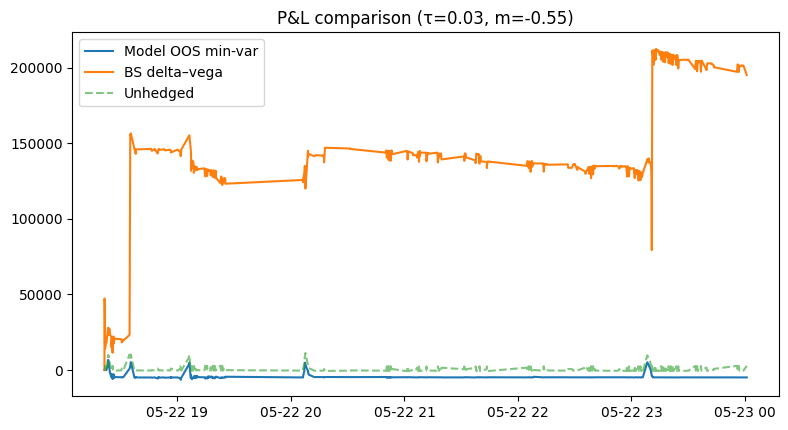

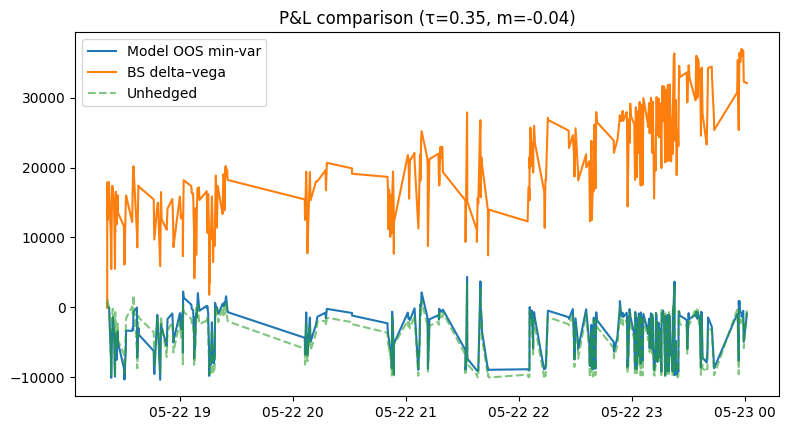

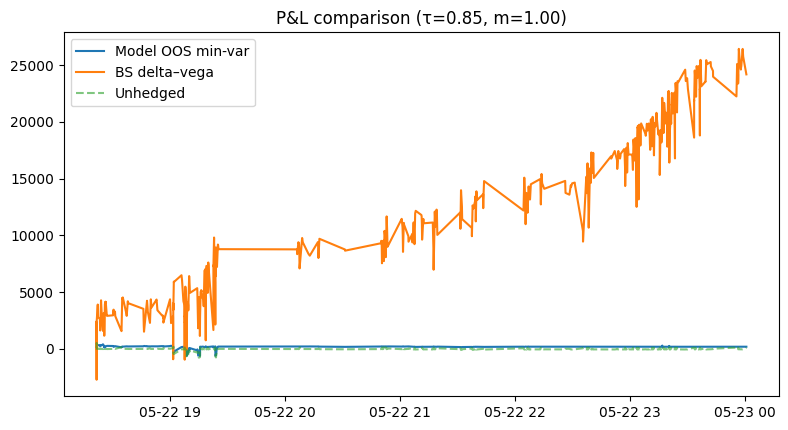

In [119]:
# --- Imports ---------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, exp, log
from scipy.stats import norm
from sklearn.linear_model import Ridge

# You already have these in your session:
# test_proj:  DataFrame [time × node] of normalized calls c = C/F (arbitrage-free)
# common_nodes: ndarray [N,2] with (tau, m) for each column of test_proj
# test_df: raw cleaned test dataframe with 'timestamp','underlying_price'
# (If names differ, tweak the two lines marked "HOOKS" near the bottom.)

# --- Constants -------------------------------------------------------------
SEC_PER_YEAR = 365.25 * 24 * 3600.0

# --- Helpers: tau decay & price reconstruction ----------------------------
def decaying_tau(idx, tau0, t0=None):
    ts = pd.to_datetime(idx)
    if t0 is None: t0 = ts[0]
    elap_s = (ts - t0).astype('timedelta64[ns]').astype(np.int64)/1e9
    tau = np.maximum(tau0 - elap_s/SEC_PER_YEAR, 1e-8)
    return pd.Series(tau, index=idx)

def c_to_dollar_prices(c_series: pd.Series,
                       tau0: float,
                       S_series: pd.Series,
                       r: float = 0.0,
                       q: float = 0.0) -> pd.Series:
    c = c_series.sort_index()
    S = S_series.reindex(c.index).ffill().bfill()
    tau_t = decaying_tau(c.index, tau0)
    F_t = S * np.exp((r - q) * tau_t)
    return pd.Series(c.values * F_t.values, index=c.index, name=c.name)

# --- Black–Scholes utilities ----------------------------------------------
def _bs_call_price(S, K, tau, r=0.0, q=0.0, sigma=0.2):
    if tau <= 0 or sigma <= 1e-12:
        return max(S*np.exp(-q*tau) - K*np.exp(-r*tau), 0.0)
    F = S*np.exp((r-q)*tau)
    v = sigma*sqrt(tau)
    d1 = (log(F/K) + 0.5*v*v)/v
    d2 = d1 - v
    return np.exp(-r*tau)*(F*norm.cdf(d1) - K*norm.cdf(d2))

def _bs_greeks_call(S, K, tau, r=0.0, q=0.0, sigma=0.2):
    if tau <= 0 or sigma <= 1e-12:
        delta = float(S*np.exp(-q*tau) > K*np.exp(-r*tau)) * np.exp(-q*tau)
        return delta, 0.0
    F = S*np.exp((r-q)*tau)
    v = sigma*sqrt(tau)
    d1 = (log(F/K) + 0.5*v*v)/v
    delta = np.exp(-q*tau)*norm.cdf(d1)
    vega  = np.exp(-r*tau)*F*norm.pdf(d1)*sqrt(tau)
    return float(delta), float(vega)

def _implied_vol_call(price, S, K, tau, r=0.0, q=0.0,
                      lo=1e-6, hi=5.0, tol=1e-7, maxit=100):
    disc = np.exp(-r*tau); dq = np.exp(-q*tau)
    intrinsic = max(S*dq - K*disc, 0.0)
    if price <= intrinsic + 1e-12:
        return lo
    f_lo = _bs_call_price(S,K,tau,r,q,lo) - price
    f_hi = _bs_call_price(S,K,tau,r,q,hi) - price
    k = 0
    while f_hi < 0 and hi < 50.0:
        hi *= 2.0
        f_hi = _bs_call_price(S,K,tau,r,q,hi) - price
        k += 1
        if k > 10: break
    for _ in range(maxit):
        mid = 0.5*(lo+hi)
        f_mid = _bs_call_price(S,K,tau,r,q,mid) - price
        if abs(f_mid) < tol or (hi-lo) < 1e-7:
            return float(max(mid, 1e-8))
        if np.sign(f_mid) == np.sign(f_lo):
            lo, f_lo = mid, f_mid
        else:
            hi = mid
    return float(max(0.5*(lo+hi), 1e-8))

# --- BS hedge engine (re-hedge each step) ---------------------------------
def bs_delta_vega_hedge(C_tgt, C_hed, S, tau0_tgt, m_tgt, tau0_hed, m_hed,
                        r=0.0, q=0.0, rehedge_every=1, fee_bps=0.0,
                        cap_h=15.0, iv_smooth=0.1):
    idx = C_tgt.index
    tau_t = decaying_tau(idx, tau0_tgt)
    tau_h = decaying_tau(idx, tau0_hed)

    # lock strikes to forward at t0
    S0 = float(S.iloc[0])
    K_tgt = float(S0*np.exp((r-q)*tau0_tgt) * np.exp(m_tgt))
    K_hed = float(S0*np.exp((r-q)*tau0_hed) * np.exp(m_hed))

    # positions & cash
    delta = np.zeros(len(idx))
    hedge_u = np.zeros(len(idx))
    cash = np.zeros(len(idx))
    pnl = np.zeros(len(idx))

    sigT_prev = None; sigH_prev = None

    # compute greeks, hedge, self-financing
    # initial greeks
    sigT = _implied_vol_call(C_tgt.iloc[0], S.iloc[0], K_tgt, tau_t.iloc[0], r, q)
    sigH = _implied_vol_call(C_hed.iloc[0], S.iloc[0], K_hed, tau_h.iloc[0], r, q)
    dT, vT = _bs_greeks_call(S.iloc[0], K_tgt, tau_t.iloc[0], r, q, sigT)
    dH, vH = _bs_greeks_call(S.iloc[0], K_hed, tau_h.iloc[0], r, q, sigH)
    h = 0.0 if abs(vH) < 1e-10 else np.clip(vT / vH, -cap_h, cap_h)

    # set initial positions offsetting NET option delta
    delta[0]   = -(dT + h*dH)
    hedge_u[0] = -h
    cash[0]    = -(delta[0]*S.iloc[0] + hedge_u[0]*C_hed.iloc[0])
    if fee_bps>0:
        cash[0] -= (abs(delta[0])*S.iloc[0] + abs(hedge_u[0])*C_hed.iloc[0])*(fee_bps*1e-4)

    for t in range(1, len(idx)):
        dt_years = (idx[t]-idx[t-1]).total_seconds()/SEC_PER_YEAR
        cash[t] = cash[t-1] * np.exp(r*dt_years)

        # mark-to-market
        pnl[t] = (C_tgt.iloc[t] + delta[t-1]*S.iloc[t] + hedge_u[t-1]*C_hed.iloc[t] + cash[t])

        if (t % rehedge_every) != 0:
            delta[t]   = delta[t-1]
            hedge_u[t] = hedge_u[t-1]
            continue

        # smooth IVs (helps HF stability)
        sigT_raw = _implied_vol_call(C_tgt.iloc[t], S.iloc[t], K_tgt, tau_t.iloc[t], r, q)
        sigH_raw = _implied_vol_call(C_hed.iloc[t], S.iloc[t], K_hed, tau_h.iloc[t], r, q)
        sigT = sigT_raw if sigT_prev is None else (1-iv_smooth)*sigT_prev + iv_smooth*sigT_raw
        sigH = sigH_raw if sigH_prev is None else (1-iv_smooth)*sigH_prev + iv_smooth*sigH_raw
        sigT_prev, sigH_prev = sigT, sigH

        dT, vT = _bs_greeks_call(S.iloc[t], K_tgt, tau_t.iloc[t], r, q, sigT)
        dH, vH = _bs_greeks_call(S.iloc[t], K_hed, tau_h.iloc[t], r, q, sigH)
        h = 0.0 if abs(vH) < 1e-10 else np.clip(vT / vH, -cap_h, cap_h)

        # new target positions (offset NET option delta)
        new_delta = -(dT + h*dH)
        new_h     = -h
        d_delta = new_delta - delta[t-1]
        d_hedge = new_h - hedge_u[t-1]

        cash[t] -= (d_delta*S.iloc[t] + d_hedge*C_hed.iloc[t])
        if fee_bps>0:
            cash[t] -= (abs(d_delta)*S.iloc[t] + abs(d_hedge)*C_hed.iloc[t])*(fee_bps*1e-4)

        delta[t], hedge_u[t] = new_delta, new_h
        pnl[t] = (C_tgt.iloc[t] + delta[t]*S.iloc[t] + hedge_u[t]*C_hed.iloc[t] + cash[t])

    pnl -= pnl[0]
    return pd.DataFrame({'pnl_bs': pnl, 'cash': cash, 'delta_pos': delta, 'hedge_units': hedge_u}, index=idx)

# --- Rolling OOS minimum-variance hedge (your model) -----------------------
def rolling_minvar_oos(C_tgt_px: pd.Series, S_px: pd.Series, C_hed_px: pd.Series,
                       window: int = 600, alpha: float = 1e-3):
    """
    Walk-forward hedge: at time t use past `window` differences to fit Ridge on
       dC_tgt ≈ h_S dS + h_O dC_hed (no intercept),
    then apply (h_S,h_O) between t and t+1. Returns self-financing P&L.
    """
    base = pd.concat([C_tgt_px.rename('C_tgt'), S_px.rename('S'), C_hed_px.rename('C_hed')], axis=1)\
             .dropna().sort_index()
    d = base.diff().dropna()
    y = d['C_tgt'].values  # (T-1,)
    X = d[['S','C_hed']].values  # (T-1,2)

    B = len(y)
    hS = np.zeros(B)
    hO = np.zeros(B)
    rr = Ridge(alpha=alpha, fit_intercept=False)

    for t in range(B):
        i0 = max(0, t - window)
        rr.fit(X[i0:t+1], y[i0:t+1])
        hS[t], hO[t] = rr.coef_

    # self-financing with positions set at each t to (-hS_t, -hO_t)
    idx = d.index
    delta = np.zeros(B+1)      # spot position
    hedge_u = np.zeros(B+1)    # hedge option units
    cash = np.zeros(B+1)
    pnl = np.zeros(B+1)

    # initial positions at first diff time (idx[0] corresponds to between 0 and 1)
    t0 = 0
    delta[t0]   = -hS[t0]
    hedge_u[t0] = -hO[t0]
    cash[t0]    = -(delta[t0]*S_px.loc[idx[t0]] + hedge_u[t0]*C_hed_px.loc[idx[t0]])
    pnl[t0]     = (C_tgt_px.loc[idx[t0]] + delta[t0]*S_px.loc[idx[t0]] + hedge_u[t0]*C_hed_px.loc[idx[t0]] + cash[t0])

    for k in range(1, B+1):
        t = k-1
        # mark at current time (use idx[t] for p&l times after first)
        pnl[k] = (C_tgt_px.loc[idx[t]] + delta[k-1]*S_px.loc[idx[t]] +
                  hedge_u[k-1]*C_hed_px.loc[idx[t]] + cash[k-1])

        # set new positions for next step with (-hS_{t+1}, -hO_{t+1}) if available
        if t+1 < B:
            new_delta = -hS[t+1]
            new_hedge = -hO[t+1]
            d_delta   = new_delta - delta[k-1]
            d_hedge   = new_hedge - hedge_u[k-1]
            cash[k]   = cash[k-1] - (d_delta*S_px.loc[idx[t]] + d_hedge*C_hed_px.loc[idx[t]])
            delta[k], hedge_u[k] = new_delta, new_hedge
        else:
            cash[k]   = cash[k-1]
            delta[k], hedge_u[k] = delta[k-1], hedge_u[k-1]

    pnl = pnl - pnl[0]
    # align to full base index (including the first price time)
    out_idx = pd.Index([base.index[0]] + list(idx))
    return pd.DataFrame({'pnl_model': pnl}, index=out_idx)

# --- Driver: pick targets, build $ series, run both hedges -----------------
def nearest_atm_same_tau(nodes: np.ndarray, target_idx: int) -> int:
    tau = nodes[target_idx, 0]
    same_tau = np.where(np.isclose(nodes[:,0], tau))[0]
    # choose nearest |m|, exclude self
    m_abs = np.abs(nodes[same_tau, 1])
    order = np.argsort(m_abs)
    for j in order:
        cand = int(same_tau[j])
        if cand != target_idx:
            return cand
    return int(target_idx)

def run_oos_vs_bs_for_targets(panel_c: pd.DataFrame,
                              nodes: np.ndarray,
                              S_series: pd.Series,
                              targets: list[int],
                              window: int = 600,
                              alpha: float = 1e-3,
                              r: float = 0.0, q: float = 0.0,
                              rehedge_every: int = 1):
    results = []
    for tidx in targets:
        hidx = nearest_atm_same_tau(nodes, tidx)

        tau0_t, m_t = float(nodes[tidx,0]), float(nodes[tidx,1])
        tau0_h, m_h = float(nodes[hidx,0]), float(nodes[hidx,1])

        # reconstruct $ prices
        C_tgt_px = c_to_dollar_prices(panel_c.iloc[:, tidx], tau0_t, S_series, r, q)
        C_hed_px = c_to_dollar_prices(panel_c.iloc[:, hidx], tau0_h, S_series, r, q)
        Sx = S_series.reindex(panel_c.index).ffill().bfill()

        # roll OOS min-var hedge (MODEL)
        pnl_model_df = rolling_minvar_oos(C_tgt_px, Sx, C_hed_px, window=window, alpha=alpha)

        # BS delta–vega hedge
        pnl_bs_df = bs_delta_vega_hedge(C_tgt_px, C_hed_px, Sx, tau0_t, m_t, tau0_h, m_h,
                                        r=r, q=q, rehedge_every=rehedge_every,
                                        fee_bps=0.0, cap_h=15.0, iv_smooth=0.1)

        # align & plot
        joined = pnl_bs_df.join(pnl_model_df, how='outer').ffill().bfill()
        unhedged = (C_tgt_px - C_tgt_px.iloc[0]).rename('pnl_unhedged')
        joined = joined.join(unhedged, how='left')

        plt.figure(figsize=(8,4.4))
        plt.plot(joined.index, joined['pnl_model'], label='Model OOS min-var')
        plt.plot(joined.index, joined['pnl_bs'], label='BS delta–vega')
        plt.plot(joined.index, joined['pnl_unhedged'], '--', alpha=0.6, label='Unhedged')
        plt.title(f'P&L comparison (τ={tau0_t:.2f}, m={m_t:.2f})')
        plt.legend(); plt.tight_layout(); plt.show()

        # quick stats
        def _incr_stats(series):
            x = np.diff(series.values, prepend=series.values[0])
            s = x.std(ddof=1); m = x.mean()
            return dict(mean=m, std=s, sharpe=(m/s if s>0 else np.nan))
        stats = {
            'target_idx': tidx,
            'hedge_idx': hidx,
            'model_incr': _incr_stats(joined['pnl_model']),
            'bs_incr': _incr_stats(joined['pnl_bs']),
            'unhedged_incr': _incr_stats(joined['pnl_unhedged'])
        }

        results.append({'meta': (tau0_t, m_t, tau0_h, m_h),
                        'joined': joined, 'stats': stats})
    return results

# --- HOOKS: build spot series aligned to panel & choose targets ------------
# 1) Spot aligned to panel times (median across instruments at each timestamp)
S_test = (
    test_df[['timestamp','underlying_price']]
    .groupby('timestamp')['underlying_price']
    .median()
    .reindex(test_proj.index)
    .ffill().bfill()
)

# 2) Choose 2–3 target nodes (or set specific indices)
N = test_proj.shape[1]
targets = [int(x) for x in np.unique(np.linspace(0, N-1, num=min(3, N)).round())]

# --- RUN -------------------------------------------------------------------
results = run_oos_vs_bs_for_targets(panel_c=test_proj,
                                    nodes=common_nodes,
                                    S_series=S_test,
                                    targets=targets,
                                    window=600,     # ~“past window” length in ticks
                                    alpha=1e-3,     # ridge to stabilize coefficients
                                    r=0.0, q=0.0,
                                    rehedge_every=1)
